#### Importing Libraries

In [207]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import math
import joblib
from sklearn.metrics import mean_squared_error, mean_pinball_loss, r2_score, classification_report, confusion_matrix, mean_absolute_percentage_error
from imblearn.over_sampling import SMOTENC
import lightgbm as lgb
import json


#### Constants

In [208]:
PATH_TO_CVS = 'output/output-energy/'
GROUP_FILE_PATH = 'group_list.json'
# This constant contains the unique quantile to represent in the scatter plot of residuals 
ONLY_QUANTILE = 0.95
# Constant containing the partial name of all the metric of a function
FUNCTION_COLUMNS = ['rate_function_', 'success_rate_function_', 'cpu_usage_function_', 'ram_usage_function_', 'power_usage_function_', 'replica_', 'overloaded_function_', 'medium_latency_function_']
# A selection of node metrics to represent in the boxplot and in the scatter plot 
COL_TO_PLOT = ['cpu_usage_idle_node', 'cpu_usage_node', 'ram_usage_idle_node', 'ram_usage_node', 'power_usage_idle_node', 'power_usage_node']
# List containing the values whose quantile regression is to be calculated
QUANTILES = [0.05, 0.95]
NODE_TYPES = ["LIGHT", "MID", "HEAVY"]
# List of functions to be considered only for predictions
PREDICT_ONLY_FUNCTIONS = ["shasum"]
#
SEED = 4850
NUM_TRAINING_EXPERIMENTS = 5

#### Utilities functions

In [209]:
# Function used to fill NaN values within the dataframe X
def fill_NaN(X):
  for col in X:
    if(col.startswith('success_rate_')):
      X.loc[:, col] = X.loc[:, col].fillna(1)
    else:
      X.loc[:, col] = X.loc[:, col].fillna(0)
  return X

In [210]:
# Function to reweight of dataframe
def resample_dataset(X, y):
  X_resampled, y_resampled = resample(X, y, replace=True, random_state=42)
  return X_resampled, y_resampled

In [211]:
# Function used to split the dataset into training and test set
def split_dataset(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

In [212]:
def convert_dataset(X_train, X_test, y_train, y_test):
  X_train_nn = X_train.astype(np.float32)
  X_test_nn = X_test.astype(np.float32)
  y_train_nn = y_train.astype(np.float32)
  y_test_nn = y_test.astype(np.float32)
  
  return X_train_nn, X_test_nn, y_train_nn, y_test_nn

In [213]:
# Function used to calculate the weighted mean squared error
def wmse_score(y_true, y_pred):
  # Calculates the weight of classes for the first target  
  median_cpu = y_true['cpu_usage_node'].median()
  w_majority_cpu = y_true[y_true['cpu_usage_node'] <= median_cpu].shape[0] / y_true.shape[0]
  w_minority_cpu = y_true[y_true['cpu_usage_node'] > median_cpu].shape[0] / y_true.shape[0]

  # Calculate the weight of classes for the second target
  median_ram = y_true['ram_usage_node'].median()
  w_majority_ram = y_true[y_true['ram_usage_node'] <= median_ram].shape[0] / y_true.shape[0]
  w_minority_ram = y_true[y_true['ram_usage_node'] > median_ram].shape[0] / y_true.shape[0]

  # Calculates the MSE for both targets
  mse_cpu = mean_squared_error(y_true['cpu_usage_node'], y_pred['cpu_usage_node'])
  mse_ram = mean_squared_error(y_true['ram_usage_node'], y_pred['ram_usage_node'])

  # Calculates WMSE as a weighted average of the MSEs for the two targets
  wmse = (w_majority_cpu * mse_cpu * y_true.shape[0] / (w_majority_cpu * y_true[y_true['cpu_usage_node'] <= median_cpu].shape[0] + w_minority_cpu * y_true[y_true['cpu_usage_node'] > median_cpu].shape[0]) +
          w_majority_ram * mse_ram * y_true.shape[0] / (w_majority_ram * y_true[y_true['ram_usage_node'] <= median_ram].shape[0] + w_minority_ram * y_true[y_true['ram_usage_node'] > median_ram].shape[0])) / 2

  return wmse

In [214]:
# Function used to calculate metrics based on the task
def metrics(task_type, y_test, y_pred, quantile):
  if(task_type == 'regression'):
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print("mape:", mape)
    mse = mean_squared_error(y_test, y_pred)
    print("mse:", mse)
    rmse = math.sqrt(mse)
    print("rmse:", rmse)
    r2 = r2_score(y_test, y_pred)
    print("R-squared score:", r2)
    std_dev = float(np.std(y_pred))
    print("Standard deviation:", std_dev)
    if quantile != 0:
      quantile_loss = mean_pinball_loss(y_test, y_pred, alpha=quantile)
      print("Quantile loss with library: ", quantile_loss)
    else:
      quantile_loss = "Not calculated for this target"
    return {"mape": mape, "mse": mse, "rmse": rmse, "r2": r2, "quantile_loss": quantile_loss, "std_dev": std_dev}    
  elif(task_type.endswith('classification')):
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    return {}

In [215]:
# Function used to plot the regression lines for the 2 targets
def plot_regression(y_test, y_pred, target_name, plot_folder = None):
    # Calculate the regression lines
    m, q = np.polyfit(y_test.ravel(), y_pred.ravel(), 1)

    # Plot the regression lines
    plt.plot(y_test, y_pred, 'o', color='red', fillstyle='none')
    plt.plot(y_test, m*y_test + q, linestyle='--')
    plt.xlabel('Observed values', fontsize = 14)
    plt.ylabel('Predicted values', fontsize = 14)
    plt.title('Regression of ' + target_name)
    plt.xlim(0, 1)  
    plt.ylim(0, 1)  
    plt.legend(fontsize = 14)
    if plot_folder is not None:
        plt.savefig(os.path.join(plot_folder, f"{target_name}.png"), dpi = 300, format = "png", bbox_inches = "tight")
        plt.close()
    else:
        plt.show()

    # Calculate residuals 
    residuals = y_test.flatten() - y_pred.flatten()

    # Scatter plot with regression line
    sns.scatterplot(x=y_test.flatten(), y=residuals, label=f'Observations')

    # Add the horizontal line near the value 0.0 of the y-axis
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Observed values', fontsize = 14)
    plt.ylabel('Residuals (Observed - Predicted values)')
    plt.title(f'Standard Regression - {target_name}')
    plt.legend(fontsize = 14)
    if plot_folder is not None:
        plt.savefig(os.path.join(plot_folder, f"{target_name}_residuals.png"), dpi = 300, format = "png", bbox_inches = "tight")
        plt.close()
    else:
        plt.show()

In [216]:
# Function used to plots quantile regression results.
def plot_quantile_regression(y_test, y_pred, target_name, plot_folder = None):
    point = 1
    line = 3
    for col in y_pred:
        m, q = np.polyfit(y_test.ravel(), y_pred[col], 1)
        plt.plot(y_test, y_pred[col], 'o', fillstyle='none', label=f'Observations - {col}')
        plt.plot(y_test, m*y_test + q, linestyle='--', zorder = line)
        point = point + 1
        line = line + 1
    plt.xlabel('Observed values', fontsize = 14)
    plt.ylabel('Predicted values', fontsize = 14)
    plt.title('Quantile Regression of ' + target_name)
    plt.xlim(0, 1)  
    plt.ylim(0, 1)  
    plt.legend(fontsize = 14)
    if plot_folder is not None:
        plt.savefig(os.path.join(plot_folder, f"{target_name}_quantile.png"), dpi = 300, format = "png", bbox_inches = "tight")
        plt.close()
    else:
        plt.show()

    # Calculate quantile residuals
    residuals = y_test.flatten() - y_pred[str(ONLY_QUANTILE)]

    # Scatter plot with regression line
    sns.scatterplot(x=y_test.flatten(), y=residuals, label=f'Observations')

    # Add the horizontal line near the value 0.0 of the y-axis
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Observed values', fontsize = 14)
    plt.ylabel('Quantile residuals (Observed - Predicted values)')
    plt.title(f'Quantile Regression {ONLY_QUANTILE} - {target_name}')
    plt.legend(fontsize = 14)
    if plot_folder is not None:
        plt.savefig(os.path.join(plot_folder, f"{target_name}_quantile_residuals.png"), dpi = 300, format = "png", bbox_inches = "tight")
        plt.close()
    else:
        plt.show()

In [217]:
# Function used to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred, target):
  # Calculate the confusion matrix
  cm = confusion_matrix(y_test[target], y_pred[target])

  # Plot the confusion matrix as heatmap
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Valori osservati')
  plt.ylabel('Valori predetti')
  plt.title('Confusion matrix')
  plt.show()

In [218]:
# Function used to train the desired model for a target variable
def train_model(target_name, X_train, y_train, quantile):
    # Classification task. Create model with autogluon
    if target_name.startswith('overloaded') or target_name.startswith('replica'):
        model_type = ""
        model = lgb.LGBMClassifier()
    # Quantile regression with LGBM
    elif quantile != 0:
        model = lgb.LGBMRegressor(objective='quantile', alpha=quantile)
        model_type = "quantile" + str(quantile).replace('.', '')
    # Regression with LGBM
    else:
        model = lgb.LGBMRegressor(objective='regression')
        model_type = "regression"
    
    model.fit(X_train, y_train)
    path = './system-forecaster-models/groups/' + target_name + "/" + model_type
    if not os.path.exists(path):
        os.makedirs(path)
    joblib.dump(model, path + "/model.joblib")

    return model



In [219]:
# Function to obtain a barchart of the type of nodes
def plot_node_type_distribution(df):
    """
    Visualizza il numero di dati per ogni tipologia di nodo in un DataFrame tramite un bar chart.

    :param df: DataFrame contenente la colonna 'node_type' con le tipologie di nodo.
    """
    # Count of occurrences for each node type
    node_counts = df['node_type'].value_counts()

    # Bar chart
    plt.figure(figsize=(10, 6))
    node_counts.plot(kind='bar')
    plt.title('Distribuzione del Numero di Dati per Tipologia di Nodo')
    plt.xlabel('Tipologia di Nodo (0 = Heavy, 1 = Mid, 2 = Light)')
    plt.ylabel('Numero di Righe')
    plt.xticks(rotation=0)  # Maintains names of horizontal node types
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

In [220]:
# Function to obtain a barchart of overloaded node distribution
def plot_overloaded_node_distribution(df):
    """
    Visualizza il numero di righe in cui 'overloaded_node' è 1 e quelle in cui è 0.

    :param df: DataFrame contenente la colonna 'overloaded_node'.
    """
    # Count of occurrences of 0 and 1 in the 'overloaded_node' column
    overloaded_counts = df['overloaded_node'].value_counts()

    # Bar chart
    plt.figure(figsize=(8, 5))
    overloaded_counts.plot(kind='bar')
    plt.title('Distribuzione di Nodi Sovraccaricati')
    plt.xlabel('Stato Sovraccarico (0 = No, 1 = Sì)')
    plt.ylabel('Numero di Righe')
    plt.xticks(rotation=0)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

In [221]:
# Create a dataset where the 0 values in the selected columns are replaced with NaN
def create_df_no_zeros(df, temp_columns, metric, df_groups, col_name, key):
    df_no_zeros = df[temp_columns].mask(df[temp_columns] == 0)
    if (metric.__contains__('rate') or metric.__contains__('usage') or metric.__contains__('power') or metric.__contains__('replica')) and not metric.__contains__('success'):
        df_groups[col_name + key] = df[temp_columns].sum(axis=1)
    elif metric.__contains__('overloaded'):
        df_groups[col_name + key] = df[temp_columns].any(axis=1).astype(int)
    else:
        df_groups[col_name + key] = df_no_zeros.mean(axis=1)
    return df_groups

In [222]:
# Function to split train/test sets
def build_train_test_data(targets, target_datasets, features_datasets, targets_pred, target_datasets_pred, features_datasets_pred):
    # Initialize dictionaries to store scaled data and train-test splits
    x_train_dict = {}
    x_test_dict = {}
    y_train_dict = {}
    y_test_dict = {}
    y_scalers = {}
    scaler_exist = False

    for target_name in targets:
        # Get the target dataset for the current iteration
        target_dataset = target_datasets[target_name]

        # Apply scaling for x (features)
        X = features_datasets[target_name]
        scaler_x = MinMaxScaler()
        scaler_x.fit(X)
        X_scaled = scaler_x.transform(X)

        # Apply scaling for y (target)
        scaler_y = MinMaxScaler()
        scaler_y.fit(target_dataset)
        y_scalers[target_name] = scaler_y
        if target_name.startswith('overloaded') or target_name.startswith('replica'):
            y_scaled = target_dataset
        else:
            y_scaled = scaler_y.transform(target_dataset)

        # Save the scaler for x
        scaler_x_path = './scalers/groups/scaler_x/' 
        if not os.path.exists(scaler_x_path):
            os.makedirs(scaler_x_path)
        if target_name.startswith('overloaded'):
            joblib.dump(scaler_x, scaler_x_path + "/" + target_name + ".joblib")
        elif not scaler_exist:
            scaler_exist = True
            joblib.dump(scaler_x, scaler_x_path + "/features.joblib")

        # Save the scaler for y
        scaler_y_path = './scalers/groups/scaler_y/'
        if not os.path.exists(scaler_y_path):
            os.makedirs(scaler_y_path)
        if not target_name.startswith("overloaded"):
            joblib.dump(scaler_y, scaler_y_path + "/" + target_name + ".joblib")

        # Split the dataset into training and testing
        x_train, x_test, y_train, y_test = train_test_split(X_scaled, y_scaled)
        x_train_dict[target_name] = x_train
        x_test_dict[target_name] = x_test
        y_train_dict[target_name] = y_train
        y_test_dict[target_name] = y_test

    # Predict-only
    x_test_dict_pred = {}
    y_test_dict_pred = {}
    for target_name in targets_pred:
        # Get the target dataset for the current iteration
        target_dataset = target_datasets_pred[target_name]
        
        # Apply scaling for x
        X = features_datasets_pred[target_name]
        scaler_x = joblib.load('./scalers/groups/scaler_x/features.joblib')
        X_scaled = scaler_x.transform(X)

        # Apply scaling for y (target)
        scaler_y = y_scalers[target_name]
        y_scaled = scaler_y.transform(target_dataset)

        x_test_dict_pred[target_name] = X_scaled
        y_test_dict_pred[target_name] = y_scaled
    
    return x_train_dict, x_test_dict, y_train_dict, y_test_dict, x_test_dict_pred, y_test_dict_pred, y_scalers

In [223]:
#Function to train One Model for each target variable
def train_all_models(targets, x_train_dict, y_train_dict):
    #Initialize a dictionary to store models
    trained_models = {}
    for target_name in targets:
        #Get the corresponding x_train for the current target
        x_train = x_train_dict[target_name]

        # Get the corresponding y_train for the current target
        y_train = y_train_dict[target_name]

        #Trains the specific model for the current target
        model = train_model(target_name, x_train, y_train, 0)  # Use the specific target's y_train
        trained_models[target_name] = model
        if not(target_name.startswith('overloaded') or target_name.startswith('replica')):
            for quantile in QUANTILES:
                model = train_model(target_name, x_train, y_train, quantile)
                trained_models[target_name + " " + str(quantile)] = model
    return trained_models

In [224]:
# Function to compute predictions and evaluate all models
def evaluate_all_models(trained_models, targets, params, x_test_dict, y_test_dict):
    # Initialize dictionary to store predictions
    all_predictions = {}
    for target_name in targets:

        # Get the test dataset for the current iteration
        x_test = x_test_dict[target_name]
        y_test = y_test_dict[target_name]
        test_data = pd.DataFrame(np.column_stack((x_test, y_test)), columns=[*params, target_name])

        # Load trained model and predict
        model = trained_models[target_name]
        y_pred = model.predict(test_data.drop(columns=[target_name]))
        all_predictions[target_name] = y_pred
        if not(target_name.startswith('overloaded') or target_name.startswith('replica')):
            y_pred_quantiles = {}
            for quantile in QUANTILES:
                model = trained_models[target_name + " " + str(quantile)]
                y_pred_quantiles[str(quantile)] = model.predict(test_data.drop(columns=[target_name]))
            all_predictions[target_name + " quantiles"] = y_pred_quantiles
    return all_predictions

In [225]:
# Function to compute prediction metrics and plot results
def compute_metrics_and_plot(all_predictions, y_test_dict, y_scalers, plot_folder = None):
    quantiles_string = [str(q) for q in QUANTILES]
    all_metrics = {}
    all_metrics_no_scale = {}
    for target_name, y_pred in all_predictions.items():
        print(f"Target: {target_name}")

        if target_name.startswith('overloaded'):
            task_type = 'binary classification'
        elif target_name.startswith('replica'):
            task_type = 'classification'
        else:
            task_type = 'regression'

        if target_name.endswith('quantiles'):
            # Get the test dataset for the current iteration
            trunc_target = target_name[0:target_name.index(' ')]
            y_test = y_test_dict[trunc_target]
            y_test_df = pd.DataFrame(y_test, columns=[trunc_target])
            y_pred_df = pd.DataFrame(y_pred, columns=quantiles_string)
            for quantile in QUANTILES:
                statistics = (y_pred_df[str(quantile)] > y_test_df[trunc_target]).value_counts(normalize=True)
                if statistics.size > 1:
                    true_percentage, false_percentage = statistics[True], statistics[False]
                    print(f"Prediction for alpha {quantile} are greater than true values in {true_percentage * 100} % of cases and less or equal in {false_percentage * 100} % of cases.")
                all_metrics[target_name] = metrics(task_type, y_test_df, y_pred_df[str(quantile)], quantile) 
            plot_quantile_regression(y_test, y_pred_df, trunc_target, plot_folder)            
            # metrics on non-scaled predictions
            y_test_df_not_scaled = pd.DataFrame()
            for col in y_test_df:
                y_test_df_not_scaled[col] = [y[0] for y in y_scalers[trunc_target].inverse_transform(pd.DataFrame(y_test_df[col])).tolist()]
            y_pred_df_not_scaled = pd.DataFrame()
            for col in y_pred_df:
                y_pred_df_not_scaled[col] = [y[0] for y in y_scalers[trunc_target].inverse_transform(pd.DataFrame(y_pred_df[col])).tolist()]
            all_metrics_no_scale[target_name] = metrics(task_type, y_test_df_not_scaled, y_pred_df_not_scaled[str(quantile)], quantile) 
        else:
            y_test = y_test_dict[target_name]
            y_test_df = pd.DataFrame(y_test, columns=[target_name])
            y_pred_df = pd.DataFrame(y_pred, columns=[target_name])
            all_metrics[target_name] = metrics(task_type, y_test_df, y_pred_df, 0)
            if task_type == 'regression':
                plot_regression(y_test, y_pred, target_name, plot_folder)   
            # metrics on non-scaled predictions
            y_test_df_not_scaled = pd.DataFrame()
            for col in y_test_df:
                y_test_df_not_scaled[col] = [y[0] for y in y_scalers[target_name].inverse_transform(pd.DataFrame(y_test_df[col])).tolist()]
            y_pred_df_not_scaled = pd.DataFrame()
            for col in y_pred_df:
                y_pred_df_not_scaled[col] = [y[0] for y in y_scalers[target_name].inverse_transform(pd.DataFrame(y_pred_df[col])).tolist()]
            all_metrics_no_scale[target_name] = metrics(task_type, y_test_df_not_scaled, y_pred_df_not_scaled, 0) 

        print("-" * 30)

    all_metrics = pd.DataFrame(all_metrics).transpose().sort_index()
    all_metrics["metric"] = all_metrics.index
    all_metrics_no_scale = pd.DataFrame(all_metrics_no_scale).transpose().sort_index()
    all_metrics_no_scale["metric"] = all_metrics_no_scale.index
    return all_metrics, all_metrics_no_scale

#### Retrieving dataset

In [226]:
df = pd.DataFrame()
for node_type in NODE_TYPES:
    # Retrieve all files in the output folder
    file_csv = [file for file in os.listdir(PATH_TO_CVS + node_type) if file.endswith('.csv')]
    # Create the dataframe by concatenating all read files
    dataframes = []
    for file in file_csv:
        file_path = os.path.join(PATH_TO_CVS + node_type, file)
        df_temp = pd.read_csv(file_path)       
        # Remove the columns in the dataframe that begin with "function_"
        df_temp.drop(columns=[col for col in df_temp if col.startswith('function_')], inplace=True)        
        # Aggiungi la colonna "node_type" e assegna il valore di 'type' a tutte le righe
        if node_type == "HEAVY":
            df_temp["node_type"] = 1
        elif node_type == "MID":
            df_temp["node_type"] = 2
        else: 
            df_temp["node_type"] = 3
        
        dataframes.append(df_temp)

    df = pd.concat([df, *dataframes], axis=0, ignore_index=True)

df = fill_NaN(df)
print(df["node_type"].value_counts())

functions = [col[14:] for col in df if col.startswith('rate')]

for function in functions:
    df.loc[df['rate_function_' + function] == 0, ['cpu_usage_function_' + function, 'ram_usage_function_' + function, 'power_usage_function_' + function, 'replica_' + function]] = 0


node_type
2    57000
3    22349
1    19435
Name: count, dtype: int64


In [227]:
df

rate_function_shasum  success_rate_function_shasum  \
0                     100.0                           1.0   
1                     100.0                           1.0   
2                     100.0                           1.0   
3                     100.0                           1.0   
4                     100.0                           1.0   
...                     ...                           ...   
98779                   0.0                           1.0   
98780                   0.0                           1.0   
98781                   0.0                           1.0   
98782                   0.0                           1.0   
98783                   0.0                           1.0   

       cpu_usage_function_shasum  ram_usage_function_shasum  \
0                          7.691                4042069.333   
1                          7.751                9199274.667   
2                          8.378                9214634.667   
3                          8.793                1366357.333   
4                          7.820                1323008.000   
...                          ...                        ...   
98779                      0.000                      0.000   
98780                      0.000                      0.000   
98781                      0.000                      0.000   
98782                      0.000                      0.000   
98783                      0.000                      0.000   

       power_usage_function_shasum  replica_shasum  \
0                        11739.653             2.0   
1                        16427.020             1.0   
2                        14245.149             2.0   
3                        24734.177             2.0   
4                        17732.391             2.0   
...                            ...             ...   
98779                        0.000             0.0   
98780                        0.000             0.0   
98781                        0.000             0.0   
98782                        0.000             0.0   
98783                        0.000             0.0   

       overloaded_function_shasum  medium_latency_function_shasum  \
0                             0.0                     107580927.0   
1                             0.0                      16880204.0   
2                             0.0                      35575151.0   
3                             0.0                      76360433.0   
4                             0.0                      87032021.0   
...                           ...                             ...   
98779                         0.0                             0.0   
98780                         0.0                             0.0   
98781                         0.0                             0.0   
98782                         0.0                             0.0   
98783                         0.0                             0.0   

       rate_function_curl  success_rate_function_curl  ...  \
0                    60.0                         1.0  ...   
1                    60.0                         1.0  ...   
2                    60.0                         1.0  ...   
3                    60.0                         1.0  ...   
4                    60.0                         1.0  ...   
...                   ...                         ...  ...   
98779                 0.0                         1.0  ...   
98780                 0.0                         1.0  ...   
98781                 0.0                         1.0  ...   
98782                 0.0                         1.0  ...   
98783                 0.0                         1.0  ...   

       overloaded_function_env  medium_latency_function_env  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0            

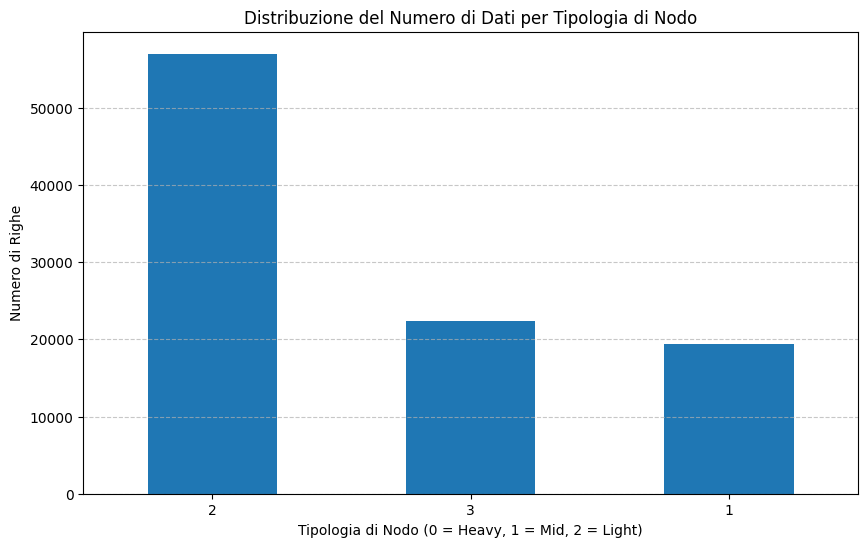

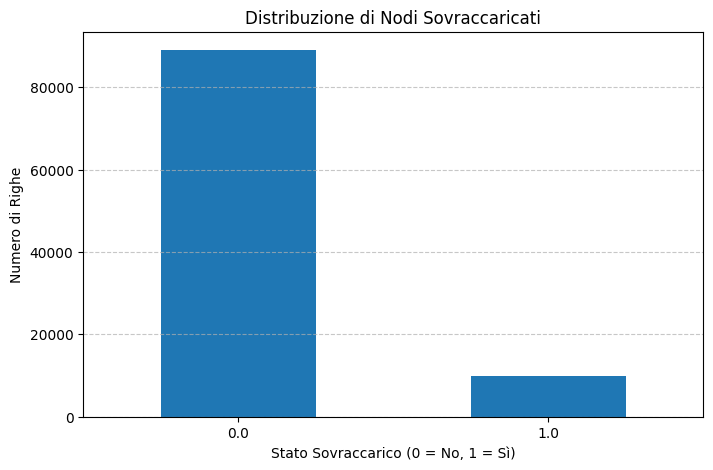

In [228]:
# Plot node type distribution
plot_node_type_distribution(df)
# Plot overloaded node distribution
plot_overloaded_node_distribution(df)

#### Removing outliers

In [229]:
# Iterate over each target column and handle outliers
functions_column = [col for col in df if col.startswith('rate')]
targets = [col for col in df if (col.startswith('power_usage_') or col.startswith('cpu_usage_') or col.startswith('ram_usage_') or col.startswith('overloaded_node') or col.startswith('medium_latency')) and 'idle' not in col]
grouped = df.groupby(functions_column + ['node_type'])
threshold = 1
for target in targets:
    print(target)
    if target != 'overloaded_node':
        mean = grouped[target].transform('mean')
        std = grouped[target].transform('std')
        outliers = (df[target] > mean + threshold * std) | (df[target] < mean - threshold * std)
        print(outliers.sum())
        df[target] = df[target].where(~outliers, mean)
    else:
        new_overloaded = grouped[target].transform('all')
        df['overloaded_node'] = new_overloaded.astype(int)
        print(df["overloaded_node"].value_counts())
df_only_useful = df[functions_column + targets + ["node_type"]]

cpu_usage_function_shasum
23887
ram_usage_function_shasum
23430
power_usage_function_shasum
23895
medium_latency_function_shasum
23610
cpu_usage_function_curl
14017
ram_usage_function_curl
13650
power_usage_function_curl
13997
medium_latency_function_curl
13920
cpu_usage_function_eat-memory
4571
ram_usage_function_eat-memory
4501
power_usage_function_eat-memory
4595
medium_latency_function_eat-memory
4564
cpu_usage_node
32752
ram_usage_node
32400
ram_usage_node_percentage
32140
power_usage_node
32498
overloaded_node
overloaded_node
0    90739
1     8045
Name: count, dtype: int64
cpu_usage_function_nmap
7319
ram_usage_function_nmap
7245
power_usage_function_nmap
7318
medium_latency_function_nmap
7301
cpu_usage_function_env
19397
ram_usage_function_env
18812
power_usage_function_env
19415
medium_latency_function_env
19202
cpu_usage_function_figlet
19900
ram_usage_function_figlet
19762
power_usage_function_figlet
19876
medium_latency_function_figlet
19790


#### Create dataset of groups

In [230]:
# Get the groups definition from the group_list.json 
with open(GROUP_FILE_PATH, 'r') as json_file:
    groups_number = json.load(json_file)

# Map groups number with the correspondent name
groups = {}
for key, value in groups_number.items():
    if "figlet" in value:
        groups["LOW_USAGE"] = value
    elif "nmap" in value:
        groups["HIGH_USAGE"] = value
    else:
        groups["MEDIUM_USAGE"] = value
groups

{'LOW_USAGE': ['curl', 'env', 'figlet', 'shasum'],
 'HIGH_USAGE': ['eat-memory', 'nmap']}

In [231]:
# Build dataframe
df_groups = pd.DataFrame()
df_groups_pred = pd.DataFrame()
group_names_pred = set()
for key, group in groups.items():
    for metric in FUNCTION_COLUMNS:
        temp_columns = []
        temp_columns_pred = []
        for fun in group:
            if fun not in PREDICT_ONLY_FUNCTIONS:
                temp_columns.append(metric + fun)
            else:
                temp_columns_pred.append(metric + fun)
                group_names_pred.add(key)

        # Rename the column name
        col_name = metric.replace('function_', '')
        if col_name == 'rate_':
            col_name = 'rate_group_'

        # Create a dataset where the 0 values in the selected columns are replaced with NaN
        df_groups = create_df_no_zeros(df, temp_columns, metric, df_groups, col_name, key)
        df_groups_pred = create_df_no_zeros(df, temp_columns_pred, metric, df_groups_pred, col_name, key)

df_groups = fill_NaN(df_groups)
df_groups_pred = fill_NaN(df_groups_pred)

# Gets all the node columns names present in df
node_metrics = [col for col in df if col.endswith('node') or 'node_type' in col] 

# Copy all the node columns in df_groups 
for metric in node_metrics:
    df_groups[metric] = df[metric]

# Copy the node type in df_groups_pred
df_groups_pred['node_type'] = df['node_type']

df_groups

rate_group_LOW_USAGE  success_rate_LOW_USAGE  cpu_usage_LOW_USAGE  \
0                      60.0                     1.0            28.338500   
1                      60.0                     1.0            28.120000   
2                      60.0                     1.0            28.826000   
3                      60.0                     1.0            21.107000   
4                      60.0                     1.0            20.506000   
...                     ...                     ...                  ...   
98779                  90.0                     1.0            12.220333   
98780                  90.0                     1.0            12.023000   
98781                 100.0                     1.0            12.879500   
98782                 100.0                     1.0            12.441000   
98783                 100.0                     1.0            12.657000   

       ram_usage_LOW_USAGE  power_usage_LOW_USAGE  replica_LOW_USAGE  \
0             1.003324e+08           15353.293000                2.0   
1             1.003324e+08           16787.090500                1.0   
2             1.003324e+08           17573.238000                2.0   
3             2.114856e+06           19581.845000                3.0   
4             1.466204e+06           20123.008000                2.0   
...                    ...                    ...                ...   
98779         7.224434e+06           35806.323000                2.0   
98780         3.266219e+06           35885.043000                2.0   
98781         8.771019e+06           41522.641167                2.0   
98782         8.978208e+06           41659.913000                2.0   
98783         8.818009e+06           41284.251000                2.0   

       overloaded_LOW_USAGE  medium_latency_LOW_USAGE  rate_group_HIGH_USAGE  \
0                         0              9.586719e+08                    0.0   
1                         0              6.293711e+08                    0.0   
2                         0              1.048772e+09                    0.0   
3                         0              1.016027e+10                   10.0   
4                         0              1.099271e+10                   10.0   
...                     ...                       ...                    ...   
98779                     0              1.445012e+07                   70.0   
98780                     0              1.402006e+07                   70.0   
98781                     0              1.483691e+07                   70.0   
98782                     0              1.903735e+07                   70.0   
98783                     0              1.763610e+07                   70.0   

       success_rate_HIGH_USAGE  ...  overloaded_HIGH_USAGE  \
0                       1.0000  ...                      0   
1                       1.0000  ...                      0   
2                       1.0000  ...                      0   
3                       0.5385  ...                      1   
4                       0.5365  ...                      1   
...                        ...  ...                    ...   
98779                   1.0000  ...                      0   
98780                   0.9880  ...                      0   
98781                   0.9810  ...                      0   
98782                   0.9840  ...                      0   
98783                   0.9755  ...                      0   

       medium_latency_HIGH_USAGE  cpu_usage_idle_node  cpu_usage_node  \
0                   0.000000e+00               59.000      124.895875   
1                   0.000000e+00               64.933      127.617000   
2                   0.000000e+00               61.667      121.317000   
3                   1.436266e+10               72.133      145.871333   
4                   1.472931e+10               62.067      142.147000   
...                          ...                  ...             ...   
98779       

In [232]:
df_groups.columns

Index(['rate_group_LOW_USAGE', 'success_rate_LOW_USAGE', 'cpu_usage_LOW_USAGE',
       'ram_usage_LOW_USAGE', 'power_usage_LOW_USAGE', 'replica_LOW_USAGE',
       'overloaded_LOW_USAGE', 'medium_latency_LOW_USAGE',
       'rate_group_HIGH_USAGE', 'success_rate_HIGH_USAGE',
       'cpu_usage_HIGH_USAGE', 'ram_usage_HIGH_USAGE',
       'power_usage_HIGH_USAGE', 'replica_HIGH_USAGE', 'overloaded_HIGH_USAGE',
       'medium_latency_HIGH_USAGE', 'cpu_usage_idle_node', 'cpu_usage_node',
       'ram_usage_idle_node', 'ram_usage_node', 'power_usage_idle_node',
       'power_usage_node', 'overloaded_node', 'node_type'],
      dtype='object')

In [233]:
df_groups.to_csv(os.path.join(PATH_TO_CVS, "grouped_results_no_outliers.csv"), index = False)

#### Partitioning into features and targets and oversampling

In [234]:
# Dataframe division by features and output
targets = [col for col in df_groups if (col.startswith('power_usage_') or col.startswith('cpu_usage_') or col.startswith('ram_usage_') or col.startswith('overloaded_node') or col.startswith('medium_latency')) and 'idle' not in col]# or col.startswith('replica')
params = [col for col in df_groups if col.startswith('rate_') or 'node_type' in col]

# Initialize a dictionary to store target datasets
target_datasets = {}
features_datasets = {}
features_datasets['original'] = df_groups[params]
for target_name in targets:
    X = df_groups[params]
    y = df_groups[[target_name]]
    node_type_index = X.columns.get_loc("node_type")

    if "overloaded" in target_name:
        print("Status of target: " + target_name)
        print(y.value_counts())
        # Oversampling
        sm = SMOTENC(random_state=42, categorical_features=[node_type_index])
        try:
            X_res, y_res = sm.fit_resample(X, y)
            result_df = pd.concat([X_res, y_res], axis=1)
            print("Status after SMOTE:")
            print(y_res.value_counts())
            print(X_res["node_type"].value_counts())
            features_datasets[target_name] = X_res
            y = y_res
        except:
            print("It was not possible to perform SMOTE for target " + target_name)
    else:
        if "node" not in target_name:
            group_name = "_".join(target_name.split("_")[-2:])
            # Drop rows whose input rate is zero
            X_res = df_groups[df_groups[f"rate_group_{group_name}"] > 0][params]
            y = df_groups[df_groups[f"rate_group_{group_name}"] > 0][[target_name]]
            features_datasets[target_name] = X_res
        else:
            # Drop rows where input rate is zero for all groups
            X_res = df_groups[df_groups[params].gt(0).sum(axis=1).ge(2)][params]
            y = df_groups[df_groups[params].gt(0).sum(axis=1).ge(2)][[target_name]]
            features_datasets[target_name] = X_res

    target_datasets[target_name] = y

# Predict-only
targets_pred = [
    col for col in df_groups_pred if (
        col.startswith('power_usage_') or col.startswith('cpu_usage_') or col.startswith('ram_usage_') or col.startswith('medium_latency')
    ) and (
        'idle' not in col and 'node' not in col
    ) and (
        any(col.endswith(g) for g in group_names_pred)
    )
]
features_datasets_pred = {'original': df_groups_pred[params]}
target_datasets_pred = {}
for target_name in targets_pred:
    group_name = "_".join(target_name.split("_")[-2:])
    X_res = df_groups_pred[df_groups_pred[f"rate_group_{group_name}"] > 0][params]
    y = df_groups_pred[df_groups_pred[f"rate_group_{group_name}"] > 0][[target_name]]
    features_datasets_pred[target_name] = X_res
    target_datasets_pred[target_name] = y

Status of target: overloaded_node
overloaded_node
0                  90739
1                   8045
Name: count, dtype: int64
Status after SMOTE:
overloaded_node
0                  90739
1                  90739
Name: count, dtype: int64
node_type
2    84261
3    65801
1    31416
Name: count, dtype: int64


#### Preprocessing

In [235]:
# Initialize dictionaries to store scaled data and train-test splits
x_train_dict, x_test_dict, y_train_dict, y_test_dict, x_test_dict_pred, y_test_dict_pred, y_scalers = build_train_test_data(targets, target_datasets, features_datasets, targets_pred, target_datasets_pred, features_datasets_pred)

#### Train models

In [236]:
# Train one model per target variable
trained_models = train_all_models(targets, x_train_dict, y_train_dict)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 72528, number of used features: 3
[LightGBM] [Info] Start training from score 0.219340
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 72528, number of used features: 3
[LightGBM] [Info] Start training from score 0.033831
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

#### Predict

In [237]:
# Compute predictions on the test set
all_predictions = evaluate_all_models(trained_models, targets, params, x_test_dict, y_test_dict)

In [238]:
# Compute predictions for the predictions-only test set
pred_only_predictions = {}
if len(PREDICT_ONLY_FUNCTIONS) > 0:
    pred_only_predictions = evaluate_all_models(trained_models, targets_pred, params, x_test_dict_pred, y_test_dict_pred)

#### Plot results

Target: cpu_usage_LOW_USAGE
mape: 0.5745222698383958
mse: 0.015123702482692373
rmse: 0.12297846349134621
R-squared score: 0.409700911143391
Standard deviation: 0.10353012235816514


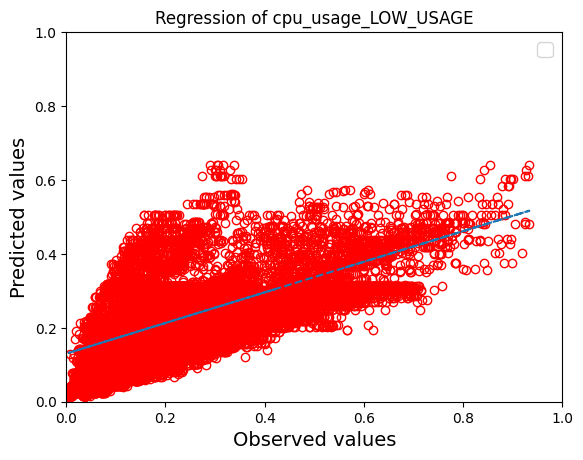

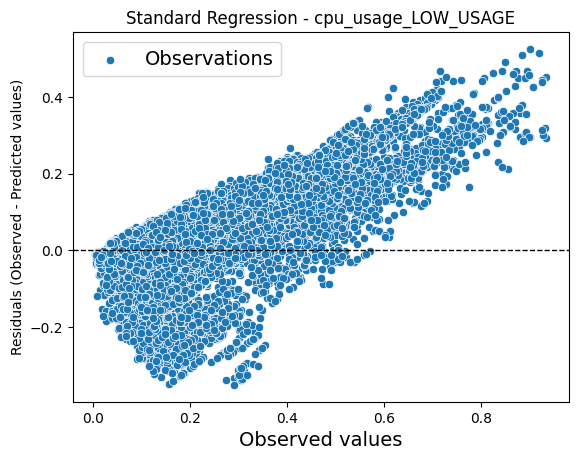

mape: 0.5699572381262489
mse: 305.96022574665193
rmse: 17.491718776228137
R-squared score: 0.409700911143391
Standard deviation: 14.72550342349126
------------------------------
Target: cpu_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.269470984820284 % of cases and less or equal in 94.73052901517973 % of cases.
mape: 0.39035794359035814
mse: 0.03089325991302056
rmse: 0.17576478575932256
R-squared score: -0.20580679230737942
Standard deviation: 0.06851342521470336
Quantile loss with library:  0.0057548449044915
Prediction for alpha 0.95 are greater than true values in 95.25582164867436 % of cases and less or equal in 4.74417835132564 % of cases.
mape: 1.5609081284841264
mse: 0.061106475756971486
rmse: 0.24719724059335996
R-squared score: -1.3850705211808183
Standard deviation: 0.18615787055904906
Quantile loss with library:  0.010727109586684968


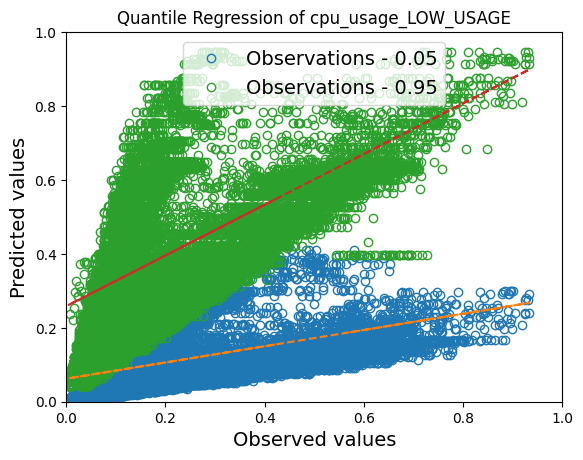

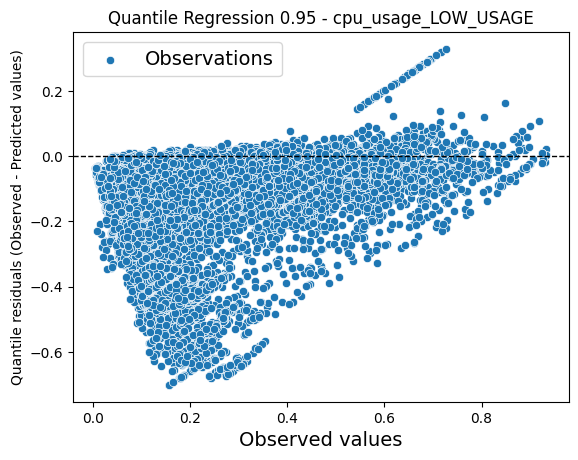

mape: 1.547092467299696
mse: 1236.215215062665
rmse: 35.15985231855596
R-squared score: -1.3850705211808187
Standard deviation: 26.47797856109578
Quantile loss with library:  1.5257597049525498
------------------------------
Target: ram_usage_LOW_USAGE
mape: 12.40235489378982
mse: 0.03655835204878741
rmse: 0.19120238504994494
R-squared score: 0.18929154564344075
Standard deviation: 0.0946269065669624


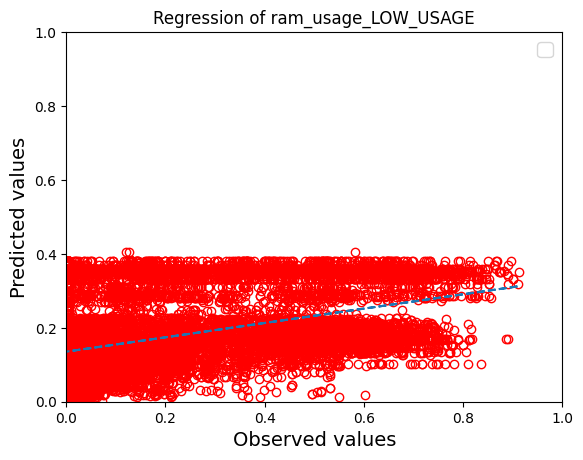

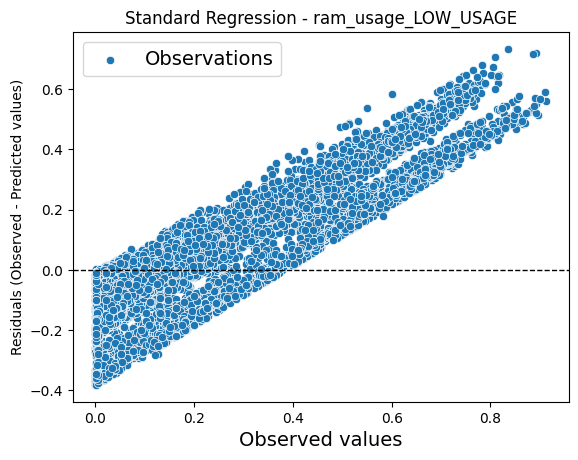

mape: 5.362991882090456
mse: 4171714178715913.0
rmse: 64588808.46335465
R-squared score: 0.18929154564344075
Standard deviation: 31965287.159659576
------------------------------
Target: ram_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 4.876535550316417 % of cases and less or equal in 95.12346444968358 % of cases.
mape: 0.8133130703285019
mse: 0.07216215644670775
rmse: 0.26863014805994456
R-squared score: -0.6002491096391502
Standard deviation: 0.008800645397144919
Quantile loss with library:  0.00831822872788144
Prediction for alpha 0.95 are greater than true values in 94.82566075195433 % of cases and less or equal in 5.174339248045663 % of cases.
mape: 37.391954779303155
mse: 0.1655241323824066
rmse: 0.4068465710589271
R-squared score: -2.6706198721258367
Standard deviation: 0.21335192655695318
Quantile loss with library:  0.019819072883290396


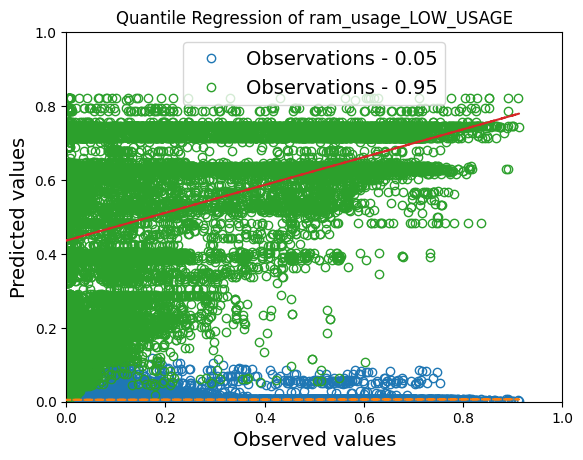

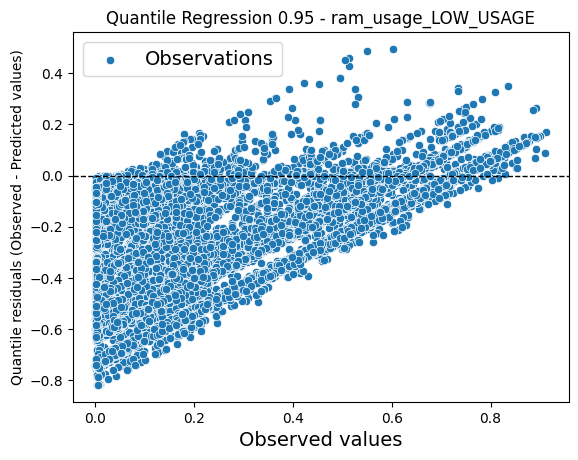

mape: 17.06070400084173
mse: 1.8888142689195396e+16
rmse: 137434139.46030802
R-squared score: -2.6706198721258367
Standard deviation: 72070998.04782861
Quantile loss with library:  6694949.448699243
------------------------------
Target: power_usage_LOW_USAGE
mape: 0.29785714597003826
mse: 0.004597390490811771
rmse: 0.06780405954522023
R-squared score: 0.7744058649269999
Standard deviation: 0.1249462109024835


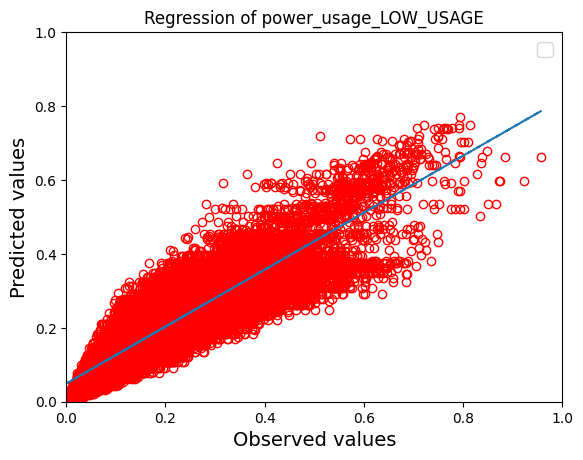

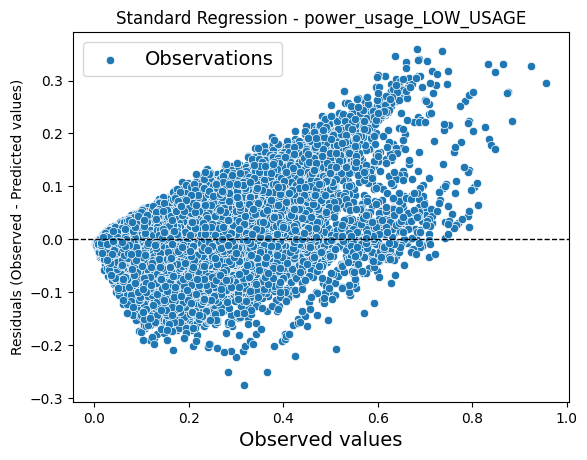

mape: 0.2966797402966535
mse: 133928354.94713087
rmse: 11572.741894085899
R-squared score: 0.7744058649269999
Standard deviation: 21325.717945458844
------------------------------
Target: power_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.223973197667204 % of cases and less or equal in 94.7760268023328 % of cases.
mape: 0.35741906049037736
mse: 0.01229167573283429
rmse: 0.11086783001770302
R-squared score: 0.39684698067557167
Standard deviation: 0.09899758594394688
Quantile loss with library:  0.004517337096857752
Prediction for alpha 0.95 are greater than true values in 95.05314968771972 % of cases and less or equal in 4.946850312280266 % of cases.
mape: 0.7649140842459666
mse: 0.01917292603867502
rmse: 0.1384663353984463
R-squared score: 0.05918375322741731
Standard deviation: 0.16912722243785736
Quantile loss with library:  0.006493158971305318


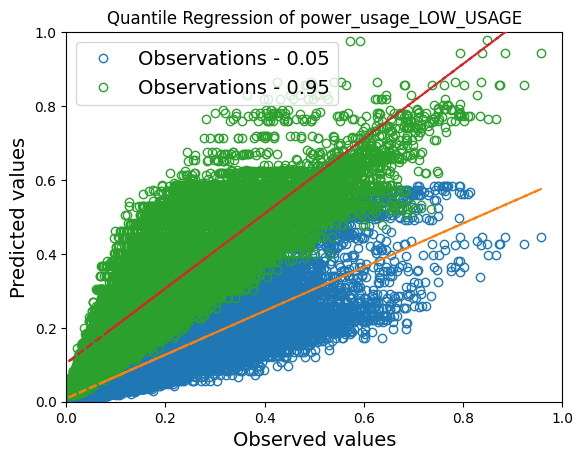

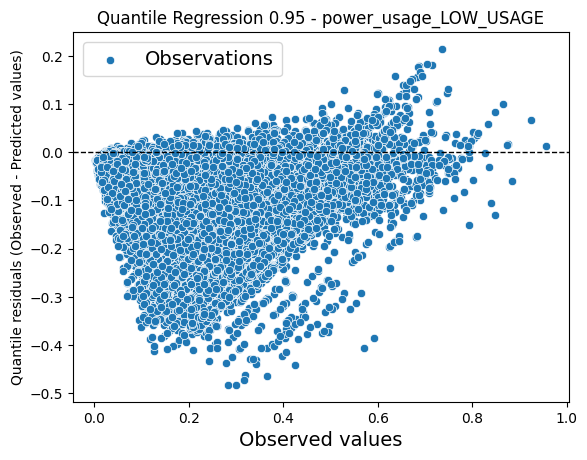

mape: 0.7615351550145981
mse: 558533900.7018641
rmse: 23633.321829608805
R-squared score: 0.05918375322741731
Standard deviation: 28866.497163516095
Quantile loss with library:  1108.2471072704657
------------------------------
Target: medium_latency_LOW_USAGE
mape: 64.53817266696707
mse: 0.009125212406576051
rmse: 0.0955259776530764
R-squared score: 0.356176727265616
Standard deviation: 0.07073941078365241


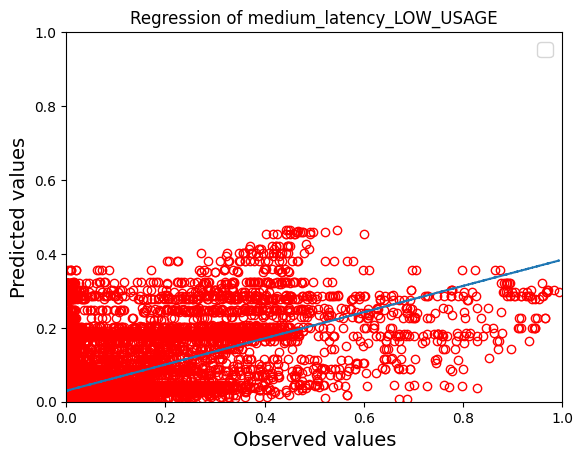

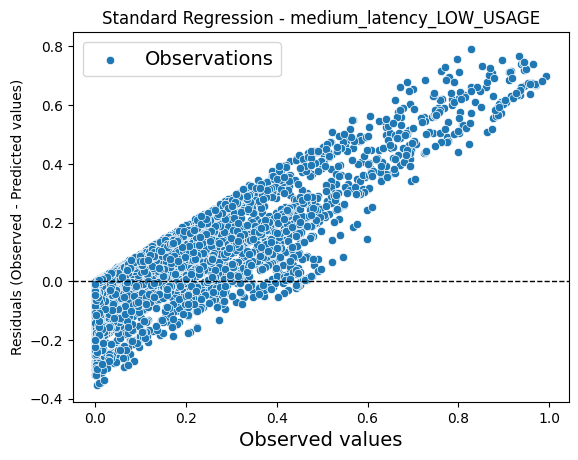

mape: 32.649587715869195
mse: 7.112962179203325e+18
rmse: 2667013719.3504133
R-squared score: 0.3561767272656162
Standard deviation: 1974991344.6993096
------------------------------
Target: medium_latency_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.199156222856434 % of cases and less or equal in 94.80084377714356 % of cases.
mape: 0.6636521921765892
mse: 0.01530634026260258
rmse: 0.12371879510649374
R-squared score: -0.07992862438502768
Standard deviation: 0.02026559407027606
Quantile loss with library:  0.0022380899515809945
Prediction for alpha 0.95 are greater than true values in 94.87943086404435 % of cases and less or equal in 5.120569135955661 % of cases.
mape: 342.93356874692785
mse: 0.046576875951130886
rmse: 0.215816764759207
R-squared score: -2.2862004052629272
Standard deviation: 0.20107905867066492
Quantile loss with library:  0.009507440484535537


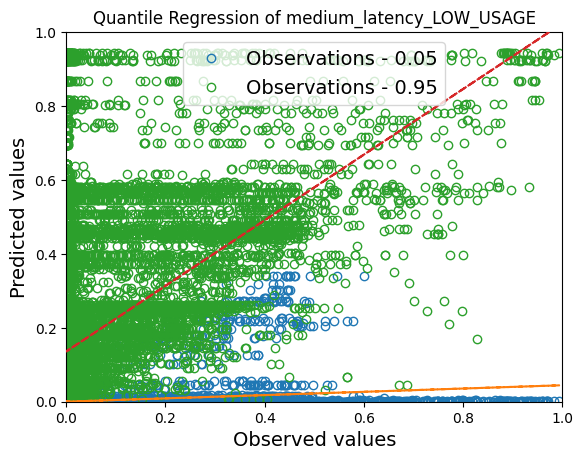

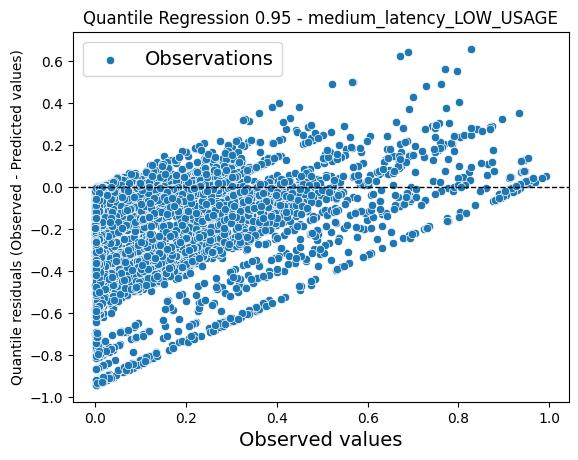

mape: 171.14520531250403
mse: 3.6305955664888308e+19
rmse: 6025442362.589515
R-squared score: -2.2862004052629263
Standard deviation: 5613976651.42304
Quantile loss with library:  265440614.49181327
------------------------------
Target: cpu_usage_HIGH_USAGE
mape: 0.1727657593859431
mse: 0.0020656348595392117
rmse: 0.04544925587442782
R-squared score: 0.9479180830321818
Standard deviation: 0.1937902176377736


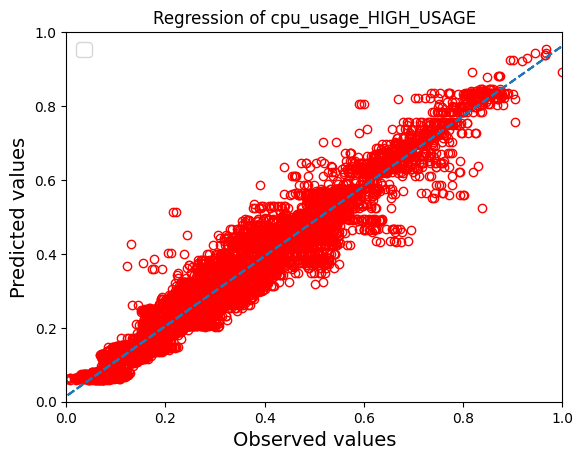

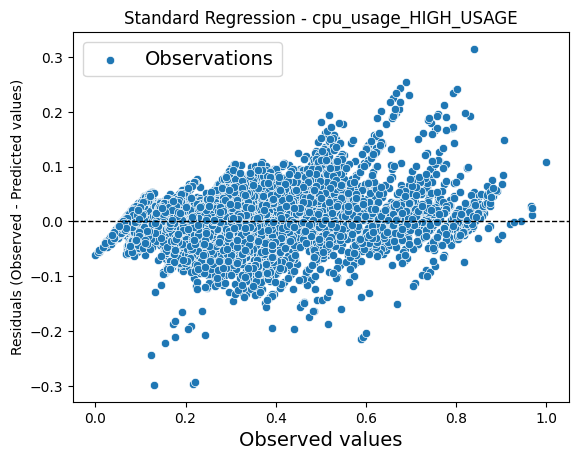

mape: 0.1363326067541997
mse: 274.4528107617961
rmse: 16.566617360275938
R-squared score: 0.9479180830321817
Standard deviation: 70.63808465070959
------------------------------
Target: cpu_usage_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 4.855703160787907 % of cases and less or equal in 95.14429683921209 % of cases.
mape: 0.2414037781334794
mse: 0.006804768633364567
rmse: 0.08249102153182834
R-squared score: 0.8284278592068466
Standard deviation: 0.17751983891381407
Quantile loss with library:  0.0035329403336220575
Prediction for alpha 0.95 are greater than true values in 94.81218506642234 % of cases and less or equal in 5.187814933577646 % of cases.
mape: 0.36115296152326715
mse: 0.007206058280204773
rmse: 0.08488850499452075
R-squared score: 0.8183099363947584
Standard deviation: 0.2101191012853869
Quantile loss with library:  0.0035116266337665396


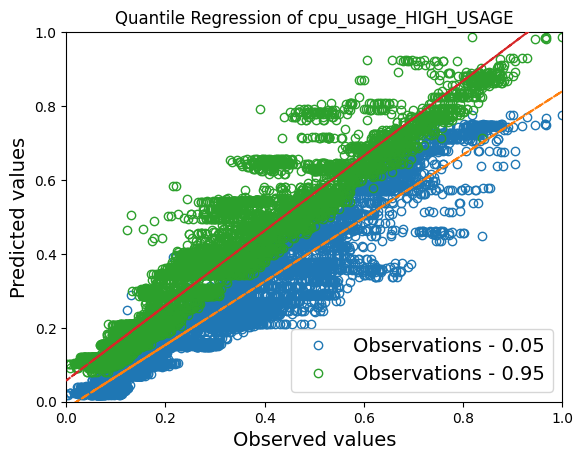

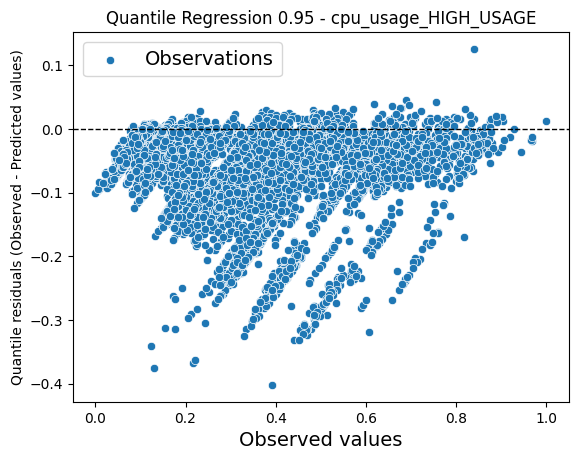

mape: 0.2912666253074117
mse: 957.4407308156544
rmse: 30.942539178542773
R-squared score: 0.8183099363947582
Standard deviation: 76.59009337133382
Quantile loss with library:  1.2800160010209742
------------------------------
Target: ram_usage_HIGH_USAGE
mape: 39.834340405265365
mse: 0.024293275516283266
rmse: 0.15586300239724393
R-squared score: 0.3004314306782805
Standard deviation: 0.1003523906140793


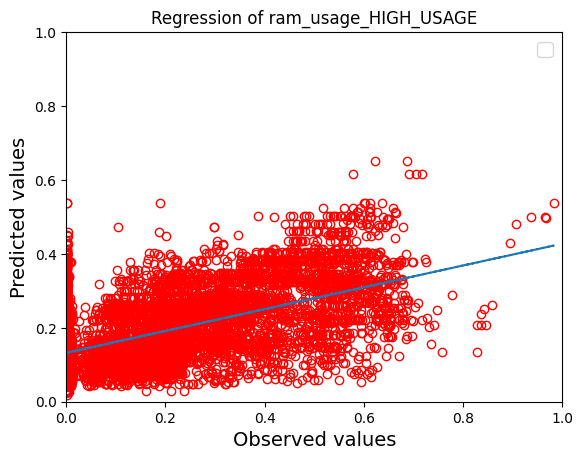

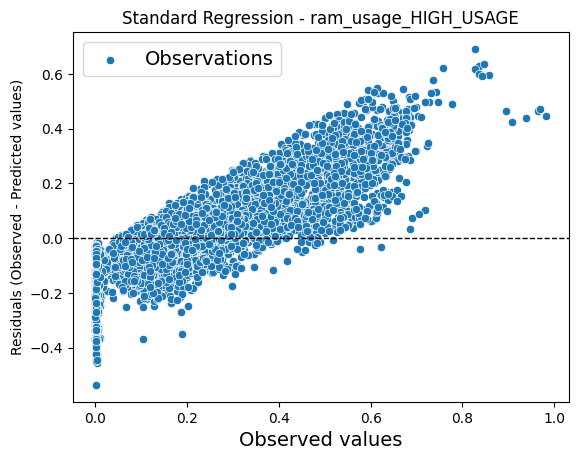

mape: 12.693593532642488
mse: 4875641666186127.0
rmse: 69825795.13465011
R-squared score: 0.30043143067828026
Standard deviation: 44957336.63869798
------------------------------
Target: ram_usage_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.474118185982593 % of cases and less or equal in 94.52588181401741 % of cases.
mape: 1.0030373582116654
mse: 0.06330376566527782
rmse: 0.25160239598477163
R-squared score: -0.822945808581979
Standard deviation: 0.03969112885881323
Quantile loss with library:  0.009102692421536163
Prediction for alpha 0.95 are greater than true values in 94.41136051305543 % of cases and less or equal in 5.5886394869445715 % of cases.
mape: 116.66276103812926
mse: 0.09576198814462873
rmse: 0.30945433935336686
R-squared score: -1.757638713513047
Standard deviation: 0.1649539504511607
Quantile loss with library:  0.013737387452243953


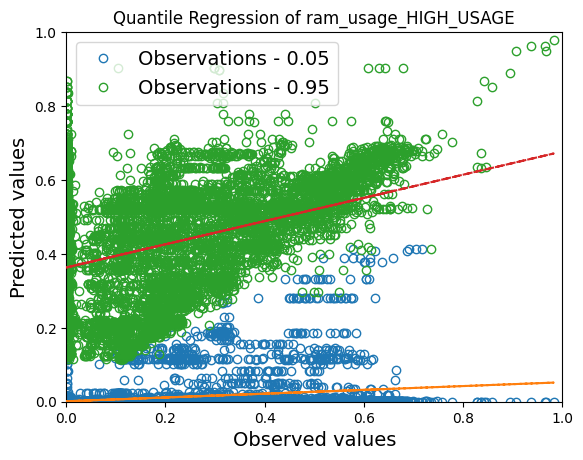

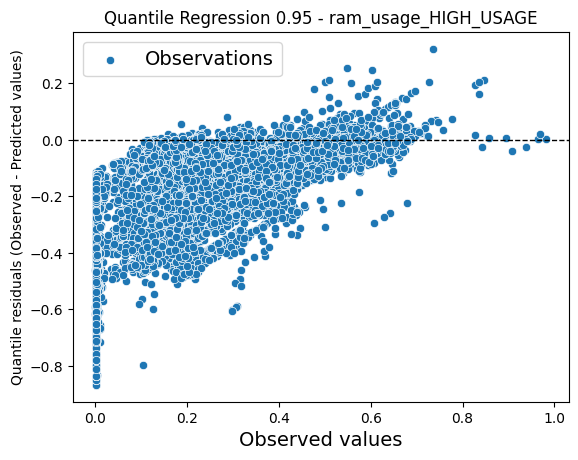

mape: 36.71410302252594
mse: 1.921935718885746e+16
rmse: 138633896.24784213
R-squared score: -1.7576387135130473
Standard deviation: 73898491.4553246
Quantile loss with library:  6154276.429764584
------------------------------
Target: power_usage_HIGH_USAGE
mape: 158599175592.92947
mse: 0.001343245738510194
rmse: 0.036650317031510025
R-squared score: 0.9579546771866604
Standard deviation: 0.17508052094293403


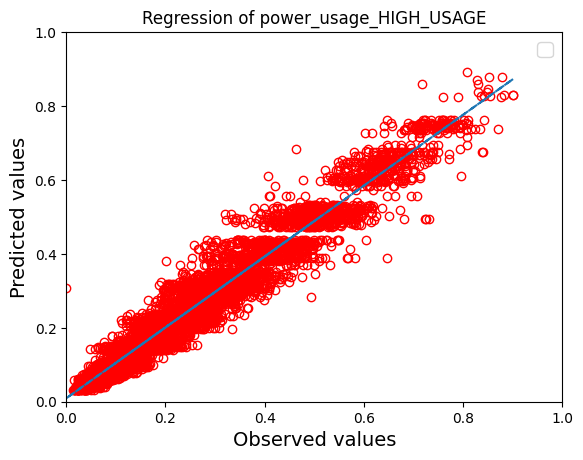

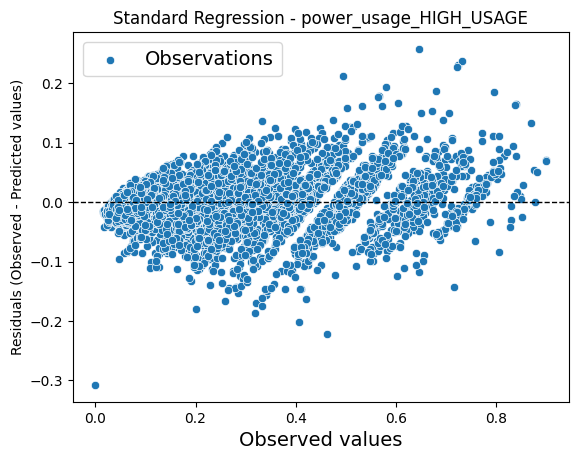

mape: 0.19936972145223292
mse: 4641726.97644979
rmse: 2154.46674990583
R-squared score: 0.9579546771866604
Standard deviation: 10292.002674995727
------------------------------
Target: power_usage_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.2908841044434265 % of cases and less or equal in 94.70911589555658 % of cases.
mape: 113209727269.66563
mse: 0.005122873361676346
rmse: 0.07157425068889192
R-squared score: 0.8396474613331479
Standard deviation: 0.15127153539044233
Quantile loss with library:  0.0032268046817108573
Prediction for alpha 0.95 are greater than true values in 94.34264773247824 % of cases and less or equal in 5.657352267521759 % of cases.
mape: 201182756507.19608
mse: 0.004886047458869648
rmse: 0.06990026794562126
R-squared score: 0.847060417316252
Standard deviation: 0.1952581137153903
Quantile loss with library:  0.003348576204414663


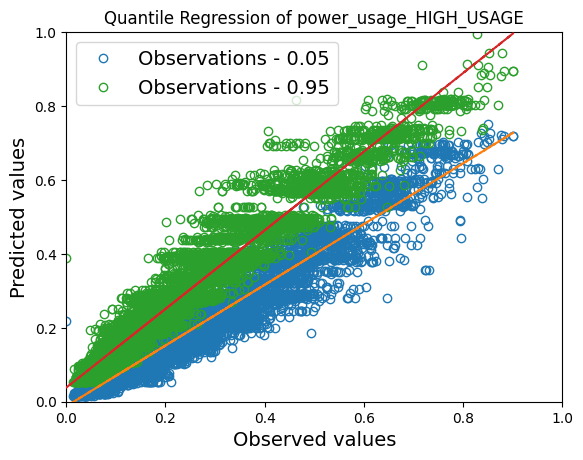

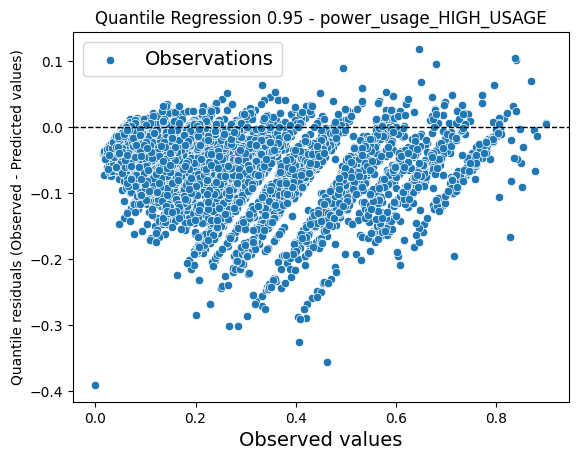

mape: 0.40939376030811664
mse: 16884251.070249774
rmse: 4109.045031421507
R-squared score: 0.847060417316252
Standard deviation: 11478.130278858536
Quantile loss with library:  196.84402963648853
------------------------------
Target: medium_latency_HIGH_USAGE
mape: 2.23508944242949
mse: 0.018849065561920782
rmse: 0.13729189911251422
R-squared score: 0.7323424167391923
Standard deviation: 0.22578524367829872


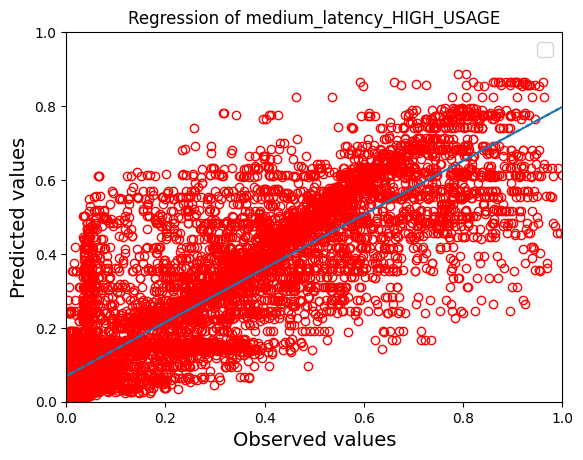

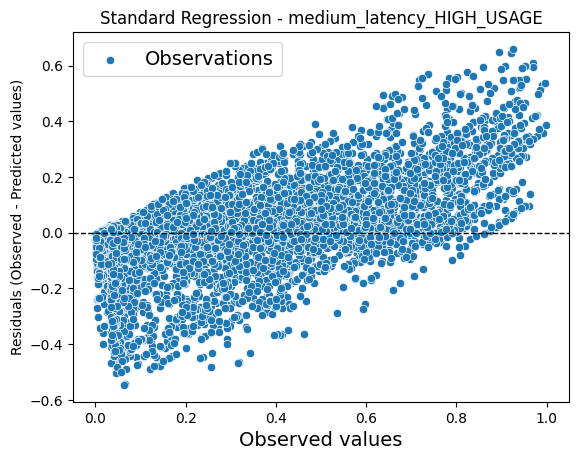

mape: 1.2750251609077459
mse: 1.6361966920413772e+19
rmse: 4044992820.8111534
R-squared score: 0.7323424167391925
Standard deviation: 6652247478.748495
------------------------------
Target: medium_latency_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 5.176362803481448 % of cases and less or equal in 94.82363719651855 % of cases.
mape: 0.5996967159165757
mse: 0.06467435657367036
rmse: 0.2543115344880573
R-squared score: 0.08162121233068009
Standard deviation: 0.15836533807137035
Quantile loss with library:  0.008228278982956633
Prediction for alpha 0.95 are greater than true values in 95.14429683921209 % of cases and less or equal in 4.855703160787907 % of cases.
mape: 6.879596306717343
mse: 0.07341412928528868
rmse: 0.27095041849993273
R-squared score: -0.042483955352875524
Standard deviation: 0.3150353179160331
Quantile loss with library:  0.010510772203826017


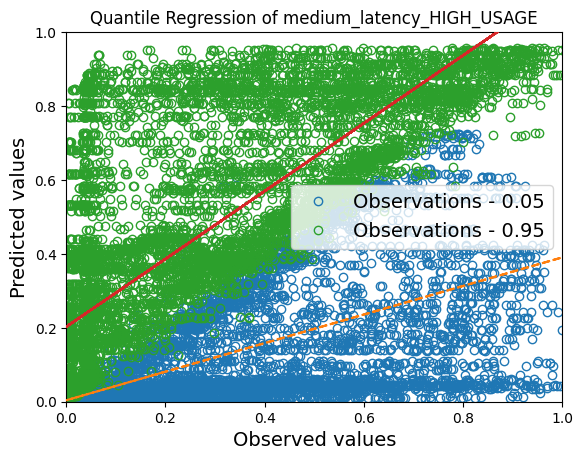

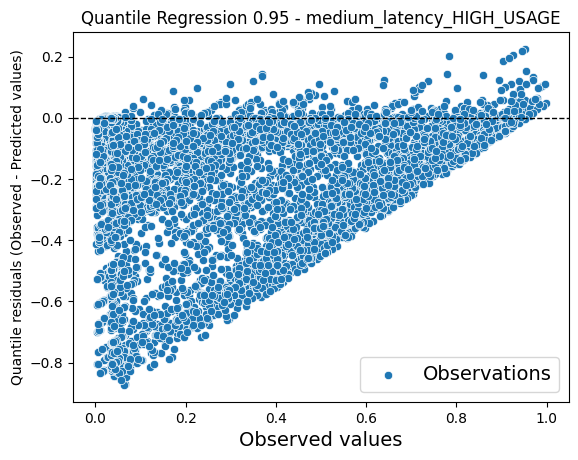

mape: 3.9192241014243363
mse: 6.3727273424288915e+19
rmse: 7982936391.096256
R-squared score: -0.042483955352875524
Standard deviation: 9281797451.341097
Quantile loss with library:  309675941.4101683
------------------------------
Target: cpu_usage_node
mape: 0.21431602513442732
mse: 0.00486774740917669
rmse: 0.06976924400605679
R-squared score: 0.8584514715263947
Standard deviation: 0.17209094087239205


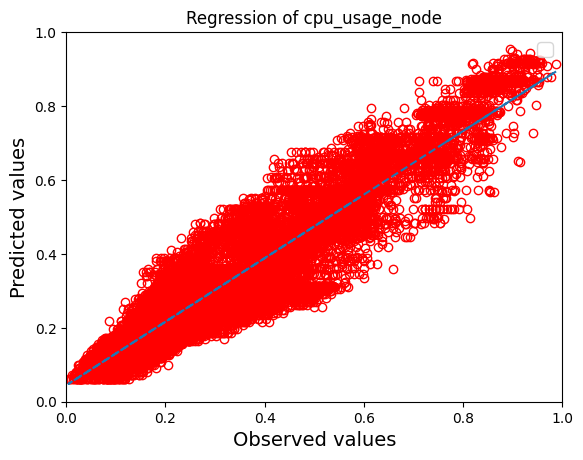

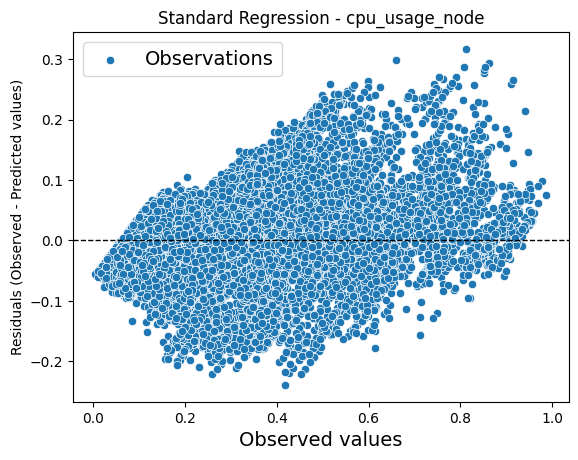

mape: 0.12163612231884158
mse: 829.6529891163532
rmse: 28.803697490363163
R-squared score: 0.8584514715263946
Standard deviation: 71.04642557528705
------------------------------
Target: cpu_usage_node quantiles
Prediction for alpha 0.05 are greater than true values in 5.2233033424255995 % of cases and less or equal in 94.7766966575744 % of cases.
mape: 0.30339540001827514
mse: 0.013948212882474413
rmse: 0.11810255239610366
R-squared score: 0.5944019189186376
Standard deviation: 0.16119254481661488
Quantile loss with library:  0.005068364547553735
Prediction for alpha 0.95 are greater than true values in 94.89883157594757 % of cases and less or equal in 5.101168424052436 % of cases.
mape: 0.5155839607082416
mse: 0.020370747397672424
rmse: 0.14272612724260553
R-squared score: 0.40764195927418667
Standard deviation: 0.18900501382109736
Quantile loss with library:  0.006475322766989135


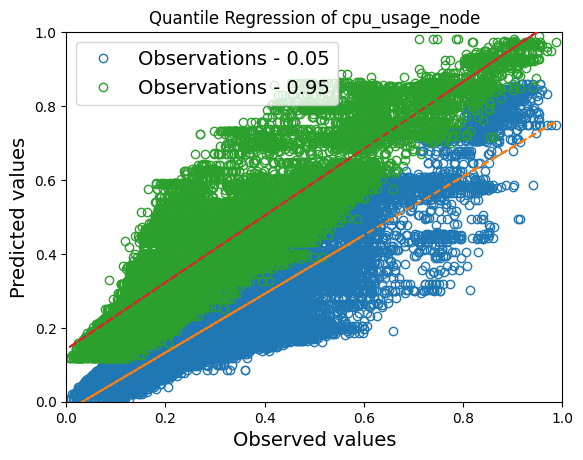

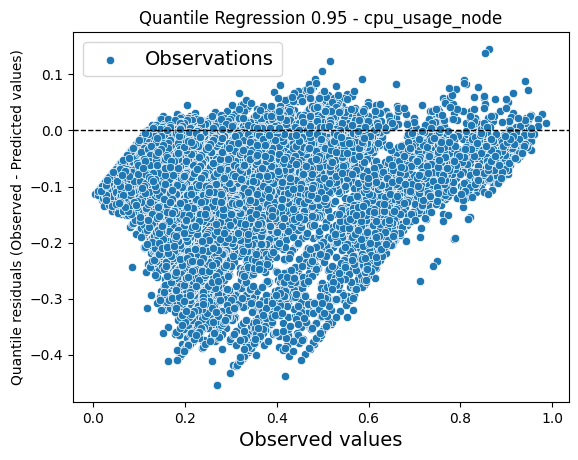

mape: 0.2841058104990751
mse: 3471.965582509879
rmse: 58.923387398467504
R-squared score: 0.40764195927418656
Standard deviation: 78.02927091760074
Quantile loss with library:  2.6732873602102507
------------------------------
Target: ram_usage_node
mape: 0.12067112767970466
mse: 0.005612584053375744
rmse: 0.07491718129625369
R-squared score: 0.6845480724090602
Standard deviation: 0.11029619983133254


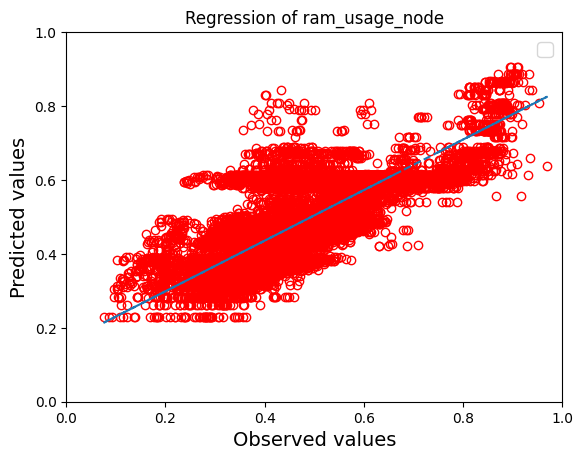

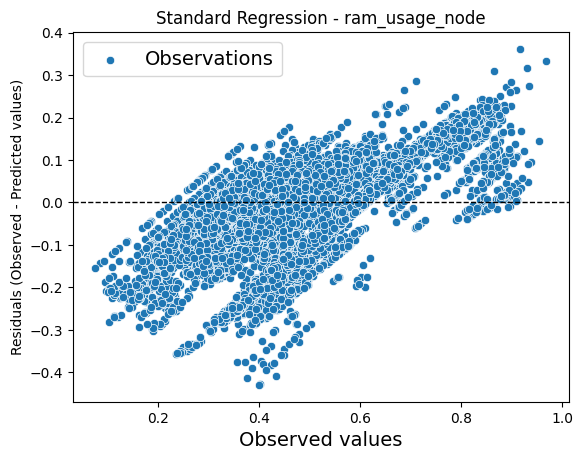

mape: 0.04067678700059735
mse: 6.1464985719050024e+16
rmse: 247921329.6976483
R-squared score: 0.6845480724090602
Standard deviation: 365000124.7997954
------------------------------
Target: ram_usage_node quantiles
Prediction for alpha 0.05 are greater than true values in 5.170378211130562 % of cases and less or equal in 94.82962178886943 % of cases.
mape: 0.2647779356196393
mse: 0.024997045208528926
rmse: 0.1581045388612513
R-squared score: -0.4049439652249991
Standard deviation: 0.10363217950511809
Quantile loss with library:  0.009333091526234922
Prediction for alpha 0.95 are greater than true values in 94.95582787118838 % of cases and less or equal in 5.044172128811628 % of cases.
mape: 0.21721883974817502
mse: 0.0144840801715328
rmse: 0.12034982414417064
R-squared score: 0.18593094267449894
Standard deviation: 0.12114295050398233
Quantile loss with library:  0.00550743649570893


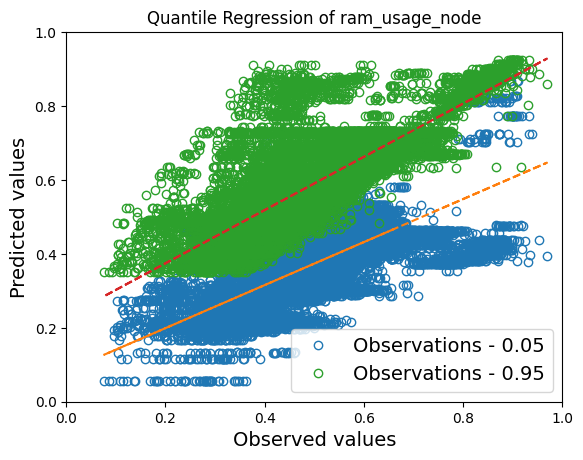

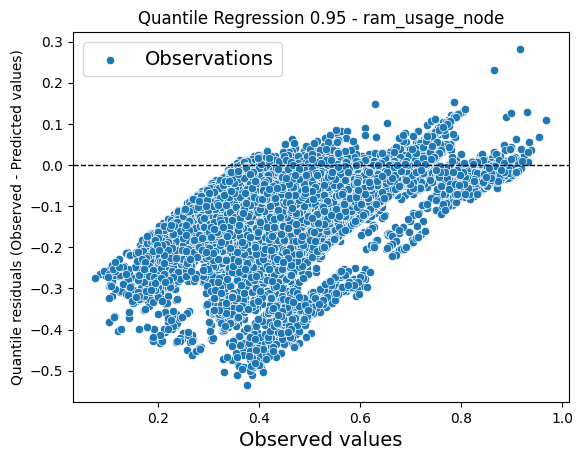

mape: 0.07178796029717513
mse: 1.586192335705656e+17
rmse: 398270302.14486945
R-squared score: 0.18593094267449917
Standard deviation: 400894972.9926047
Quantile loss with library:  18225605.336673193
------------------------------
Target: power_usage_node
mape: 0.2500863571500081
mse: 0.003046501675708467
rmse: 0.05519512365878409
R-squared score: 0.8571983099142921
Standard deviation: 0.13505830977919686


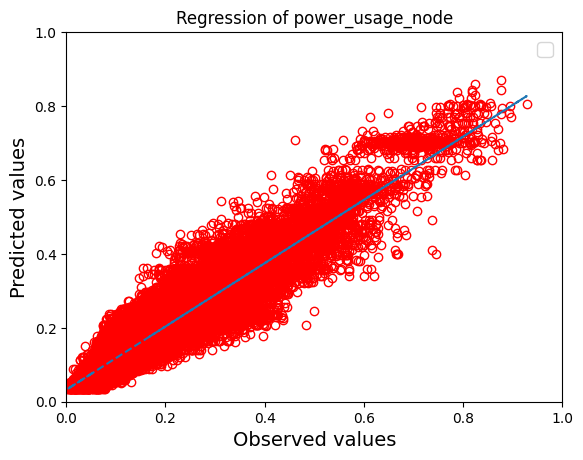

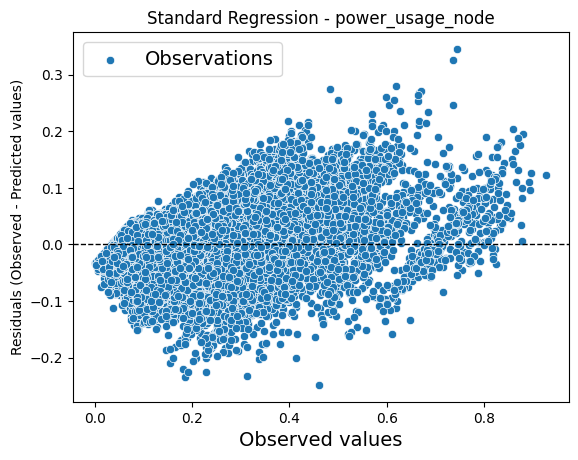

mape: 0.182870383470053
mse: 47949194669.217545
rmse: 218973.04553121954
R-squared score: 0.8571983099142921
Standard deviation: 535810.5473135038
------------------------------
Target: power_usage_node quantiles
Prediction for alpha 0.05 are greater than true values in 5.255872653991776 % of cases and less or equal in 94.74412734600823 % of cases.
mape: 0.35806576568324106
mse: 0.010044922014456923
rmse: 0.10022435838885138
R-squared score: 0.5291544226346097
Standard deviation: 0.11477601435140462
Quantile loss with library:  0.0045150720885269585
Prediction for alpha 0.95 are greater than true values in 94.60570777185198 % of cases and less or equal in 5.394292228148028 % of cases.
mape: 0.578010266844625
mse: 0.011538233651787189
rmse: 0.10741617034593623
R-squared score: 0.4591569473875866
Standard deviation: 0.15819488896693945
Quantile loss with library:  0.005305499580221478


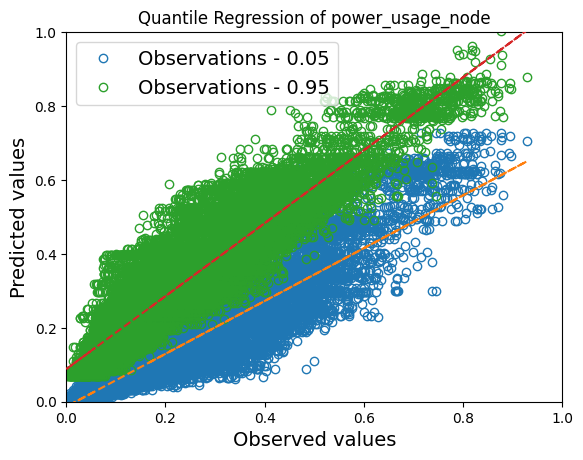

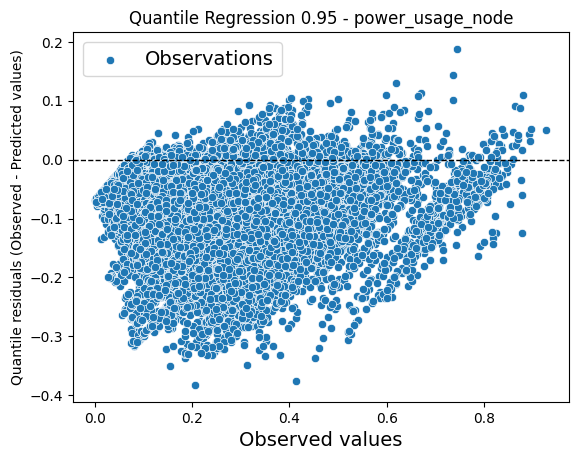

mape: 0.4183517536362357
mse: 181601413818.29443
rmse: 426147.1738945296
R-squared score: 0.4591569473875866
Standard deviation: 627599.2212411858
Quantile loss with library:  21048.261587884197
------------------------------
Target: overloaded_node
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90     22784
           1       0.87      0.95      0.91     22586

    accuracy                           0.90     45370
   macro avg       0.91      0.90      0.90     45370
weighted avg       0.91      0.90      0.90     45370

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.86      0.90     22784
         1.0       0.87      0.95      0.91     22586

    accuracy                           0.90     45370
   macro avg       0.91      0.90      0.90     45370
weighted avg       0.91      0.90      0.90     45370

------------------------------


In [239]:
all_metrics, all_metrics_no_scale = compute_metrics_and_plot(all_predictions, y_test_dict, y_scalers)

In [240]:
os.makedirs("output/metrics/groups", exist_ok = True)
all_metrics.to_csv("output/metrics/groups/all_metrics.csv")
all_metrics

mape       mse      rmse  \
cpu_usage_HIGH_USAGE                            0.172766  0.002066  0.045449   
cpu_usage_HIGH_USAGE quantiles                  0.361153  0.007206  0.084889   
cpu_usage_LOW_USAGE                             0.574522  0.015124  0.122978   
cpu_usage_LOW_USAGE quantiles                   1.560908  0.061106  0.247197   
cpu_usage_node                                  0.214316  0.004868  0.069769   
cpu_usage_node quantiles                        0.515584  0.020371  0.142726   
medium_latency_HIGH_USAGE                       2.235089  0.018849  0.137292   
medium_latency_HIGH_USAGE quantiles             6.879596  0.073414   0.27095   
medium_latency_LOW_USAGE                       64.538173  0.009125  0.095526   
medium_latency_LOW_USAGE quantiles            342.933569  0.046577  0.215817   
overloaded_node                                      NaN       NaN       NaN   
power_usage_HIGH_USAGE               158599175592.929474  0.001343   0.03665   
power_usage_HIGH_USAGE quantiles     201182756507.196075  0.004886    0.0699   
power_usage_LOW_USAGE                           0.297857  0.004597  0.067804   
power_usage_LOW_USAGE quantiles                 0.764914  0.019173  0.138466   
power_usage_node                                0.250086  0.003047  0.055195   
power_usage_node quantiles                       0.57801  0.011538  0.107416   
ram_usage_HIGH_USAGE                            39.83434  0.024293  0.155863   
ram_usage_HIGH_USAGE quantiles                116.662761  0.095762  0.309454   
ram_usage_LOW_USAGE                            12.402355  0.036558  0.191202   
ram_usage_LOW_USAGE quantiles                  37.391955  0.165524  0.406847   
ram_usage_node                                  0.120671  0.005613  0.074917   
ram_usage_node quantiles                        0.217219  0.014484   0.12035   

                                           r2                   quantile_loss  \
cpu_usage_HIGH_USAGE                 0.947918  Not calculated for this target   
cpu_usage_HIGH_USAGE quantiles        0.81831                        0.003512   
cpu_usage_LOW_USAGE                  0.409701  Not calculated for this target   
cpu_usage_LOW_USAGE quantiles       -1.385071                        0.010727   
cpu_usage_node                       0.858451  Not calculated for this target   
cpu_usage_node quantiles             0.407642                        0.006475   
medium_latency_HIGH_USAGE            0.732342  Not calculated for this target   
medium_latency_HIGH_USAGE quantiles -0.042484                        0.010511   
medium_latency_LOW_USAGE             0.356177  Not calculated for this target   
medium_latency_LOW_USAGE quantiles    -2.2862                        0.009507   
overloaded_node                           NaN                             NaN   
power_usage_HIGH_USAGE               0.957955  Not calculated for this target   
power_usage_HIGH_USAGE quantiles      0.84706                        0.003349   
power_usage_LOW_USAGE                0.774406  Not calculated for this target   
power_usage_LOW_USAGE quantiles      0.059184                        0.006493   
power_usage_node                     0.857198  Not calculated for this target   
power_usage_node quantiles           0.459157                        0.005305   
ram_usage_HIGH_USAGE                 0.300431  Not calculated for this target   
ram_usage_HIGH_USAGE quantiles      -1.757639                        0.013737   
ram_usage_LOW_USAGE                  0.189292  Not calculated for this target   
ram_usage_LOW_USAGE quantiles        -2.67062                        0.019819   
ram_usage_node                       0.684548  Not calculated for this target   
ram_usage_node quantiles             0.185931                        0.005507   

                                      std_dev  \
cpu_usage_HIGH_USAGE                  0.19379   
cpu_usage_HIGH_USAGE quantiles       0.210119   
cpu_usage_LOW_USAGE                   0

In [241]:
all_metrics_no_scale.to_csv("output/metrics/groups/all_metrics_no_scale.csv")
all_metrics_no_scale

mape                     mse  \
cpu_usage_HIGH_USAGE                   0.136333              274.452811   
cpu_usage_HIGH_USAGE quantiles         0.291267              957.440731   
cpu_usage_LOW_USAGE                    0.569957              305.960226   
cpu_usage_LOW_USAGE quantiles          1.547092             1236.215215   
cpu_usage_node                         0.121636              829.652989   
cpu_usage_node quantiles               0.284106             3471.965583   
medium_latency_HIGH_USAGE              1.275025  16361966920413771776.0   
medium_latency_HIGH_USAGE quantiles    3.919224  63727273424288915456.0   
medium_latency_LOW_USAGE              32.649588   7112962179203324928.0   
medium_latency_LOW_USAGE quantiles   171.145205  36305955664888307712.0   
overloaded_node                             NaN                     NaN   
power_usage_HIGH_USAGE                  0.19937           4641726.97645   
power_usage_HIGH_USAGE quantiles       0.409394          16884251.07025   
power_usage_LOW_USAGE                   0.29668        133928354.947131   
power_usage_LOW_USAGE quantiles        0.761535        558533900.701864   
power_usage_node                        0.18287      47949194669.217545   
power_usage_node quantiles             0.418352     181601413818.294434   
ram_usage_HIGH_USAGE                  12.693594      4875641666186127.0   
ram_usage_HIGH_USAGE quantiles        36.714103     19219357188857460.0   
ram_usage_LOW_USAGE                    5.362992      4171714178715913.0   
ram_usage_LOW_USAGE quantiles         17.060704     18888142689195396.0   
ram_usage_node                         0.040677     61464985719050024.0   
ram_usage_node quantiles               0.071788    158619233570565600.0   

                                                  rmse        r2  \
cpu_usage_HIGH_USAGE                         16.566617  0.947918   
cpu_usage_HIGH_USAGE quantiles               30.942539   0.81831   
cpu_usage_LOW_USAGE                          17.491719  0.409701   
cpu_usage_LOW_USAGE quantiles                35.159852 -1.385071   
cpu_usage_node                               28.803697  0.858451   
cpu_usage_node quantiles                     58.923387  0.407642   
medium_latency_HIGH_USAGE            4044992820.811153  0.732342   
medium_latency_HIGH_USAGE quantiles  7982936391.096256 -0.042484   
medium_latency_LOW_USAGE             2667013719.350413  0.356177   
medium_latency_LOW_USAGE quantiles   6025442362.589515   -2.2862   
overloaded_node                                    NaN       NaN   
power_usage_HIGH_USAGE                      2154.46675  0.957955   
power_usage_HIGH_USAGE quantiles           4109.045031   0.84706   
power_usage_LOW_USAGE                     11572.741894  0.774406   
power_usage_LOW_USAGE quantiles            23633.32183  0.059184   
power_usage_node                         218973.045531  0.857198   
power_usage_node quantiles               426147.173895  0.459157   
ram_usage_HIGH_USAGE                    69825795.13465  0.300431   
ram_usage_HIGH_USAGE quantiles        138633896.247842 -1.757639   
ram_usage_LOW_USAGE                    64588808.463355  0.189292   
ram_usage_LOW_USAGE quantiles         137434139.460308  -2.67062   
ram_usage_node                        247921329.697648  0.684548   
ram_usage_node quantiles              398270302.144869  0.185931   

                                                      quantile_loss  \
cpu_usage_HIGH_USAGE                 Not calculated for this target   
cpu_usage_HIGH_USAGE quantiles                             1.280016   
cpu_usage_LOW_USAGE                  Not calculated for this target   
cpu_usage_LOW_USAGE quantiles                               1.52576   
cpu_usage_node                       Not calculated for this target   
cpu_usage_node quantiles                                   2.673287   
medium_latency_HIGH_USAGE            Not calculated for this target   
medium_latency_HIGH_USAGE quantiles      

Target: cpu_usage_LOW_USAGE
mape: 2.0072873082500724
mse: 0.015437086064222843
rmse: 0.1242460706188443
R-squared score: -10.52894387801834
Standard deviation: 0.09305168588626524


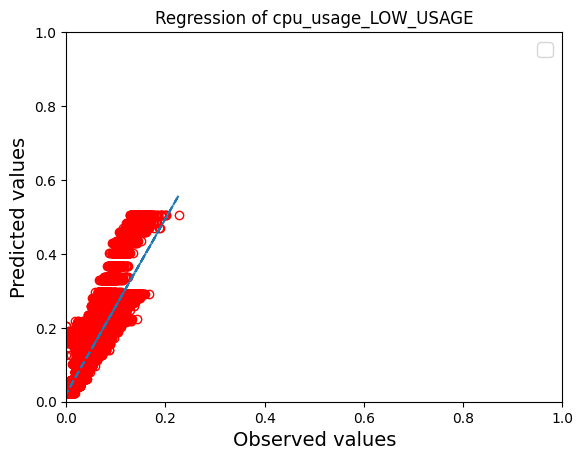

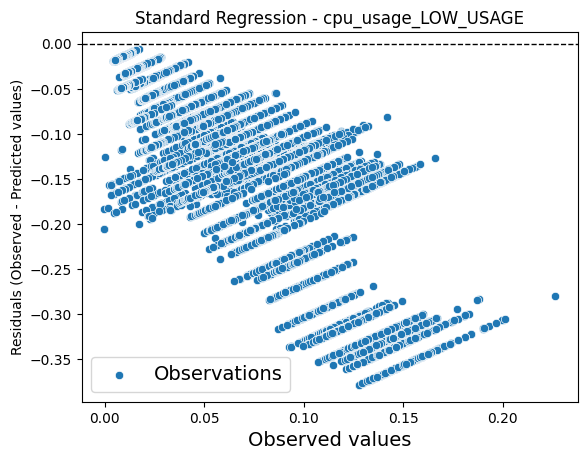

mape: 1.9505796032800133
mse: 312.3001356635579
rmse: 17.6720156084007
R-squared score: -10.528943878018337
Standard deviation: 13.23511349034705
------------------------------
Target: cpu_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 77.6103650831123 % of cases and less or equal in 22.389634916887697 % of cases.
mape: 0.17521798986768244
mse: 0.00011586914670375003
rmse: 0.010764253188389339
R-squared score: 0.9134649580896368
Standard deviation: 0.0389918167319854
Quantile loss with library:  0.006537355558172802
mape: 4.982864792341294
mse: 0.09277560105033307
rmse: 0.3045908748638624
R-squared score: -68.287992131989
Standard deviation: 0.17205904115381632
Quantile loss with library:  0.013606173130468085


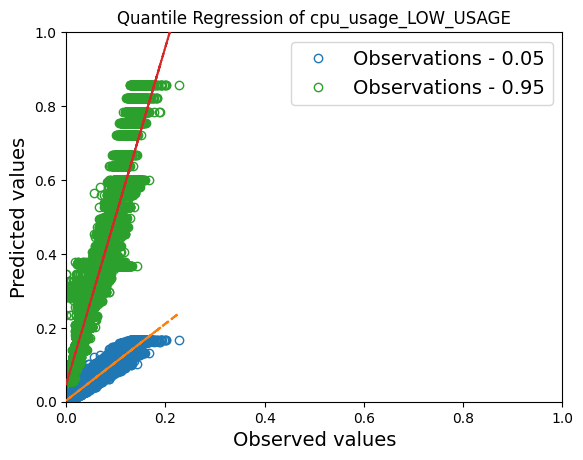

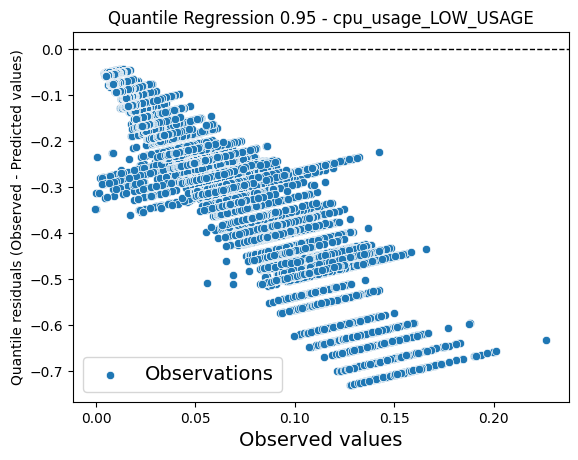

mape: 4.854695457873241
mse: 1876.8977949431282
rmse: 43.32317849538661
R-squared score: -68.28799213198899
Standard deviation: 24.47264565947191
Quantile loss with library:  1.9352604290389972
------------------------------
Target: ram_usage_LOW_USAGE
mape: 47.80045757867161
mse: 0.03325788243919817
rmse: 0.18236743799044328
R-squared score: -2.648976715851577
Standard deviation: 0.07921907458296455


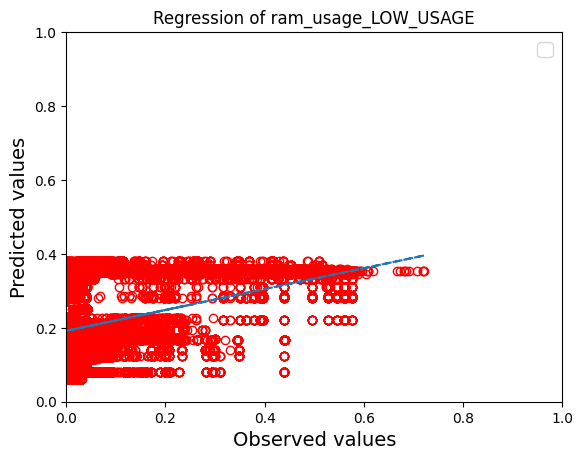

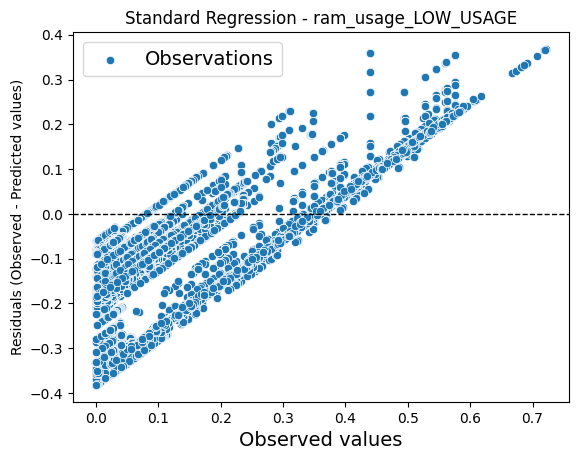

mape: 16.755823426113427
mse: 3795093923832157.0
rmse: 61604333.644899994
R-squared score: -2.648976715851576
Standard deviation: 26760469.716665693
------------------------------
Target: ram_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 27.219452583633057 % of cases and less or equal in 72.78054741636694 % of cases.
mape: 0.9521997633913223
mse: 0.01192236415407439
rmse: 0.10918957896280392
R-squared score: -0.30809378124585707
Standard deviation: 0.0021562339728937504
Quantile loss with library:  0.0032035699956627925
Prediction for alpha 0.95 are greater than true values in 99.9180680729333 % of cases and less or equal in 0.08193192706669815 % of cases.
mape: 139.19062373914647
mse: 0.3304518432924575
rmse: 0.5748494092303283
R-squared score: -35.25639979000067
Standard deviation: 0.11600221871349177
Quantile loss with library:  0.02794818187512739


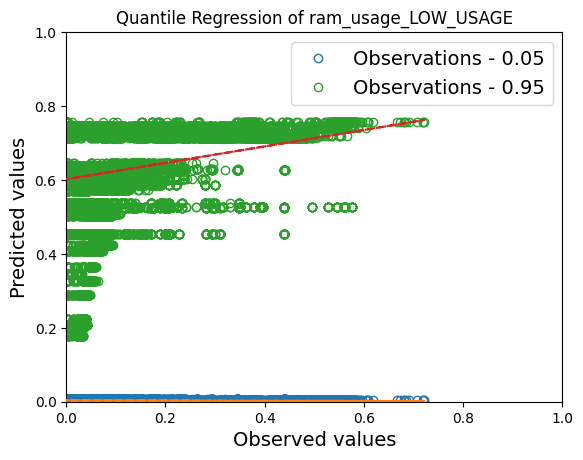

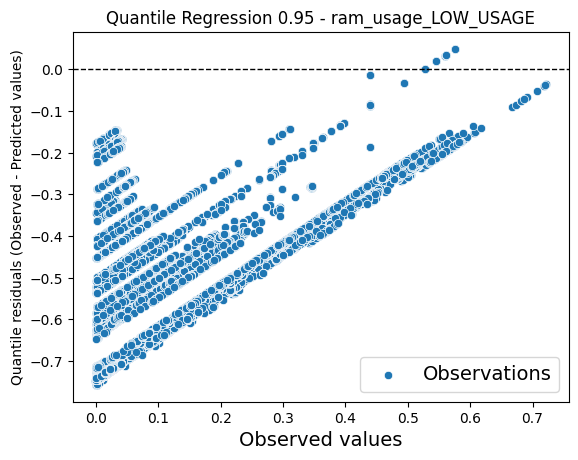

mape: 52.25892209509212
mse: 3.770822706139126e+16
rmse: 194186062.9947249
R-squared score: -35.256399790000664
Standard deviation: 39185939.46332183
Quantile loss with library:  9440989.794976002
------------------------------
Target: power_usage_LOW_USAGE
mape: 0.364824137985942
mse: 0.0014710964265717155
rmse: 0.038354874873628715
R-squared score: 0.7312007530455311
Standard deviation: 0.07726296914136446


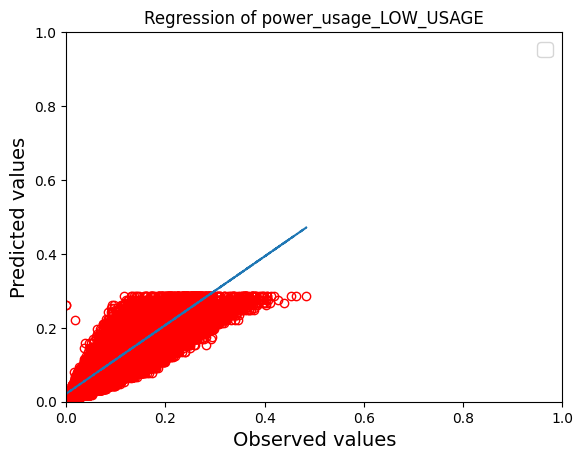

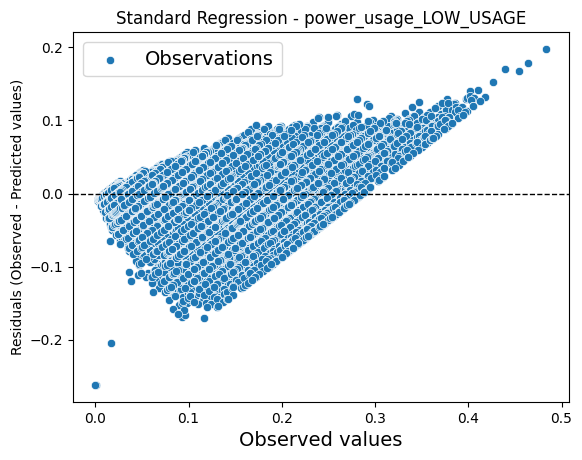

mape: 0.3415728750039895
mse: 42855077.195011996
rmse: 6546.378937627426
R-squared score: 0.7312007530455311
Standard deviation: 13187.180912780112
------------------------------
Target: power_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 4.046603991056922 % of cases and less or equal in 95.95339600894309 % of cases.
mape: 0.4266943325505185
mse: 0.0037010066143382384
rmse: 0.06083589905917589
R-squared score: 0.3237507936675491
Standard deviation: 0.04365985120196008
Quantile loss with library:  0.0024702982273171184
Prediction for alpha 0.95 are greater than true values in 98.61687797697573 % of cases and less or equal in 1.38312202302426 % of cases.
mape: 1.1551244255915092
mse: 0.013106608979733921
rmse: 0.1144840992441043
R-squared score: -1.394844117791358
Standard deviation: 0.12152221509852494
Quantile loss with library:  0.004809873049190326


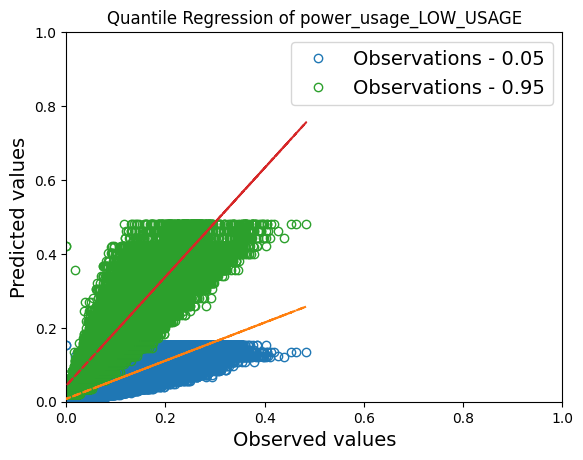

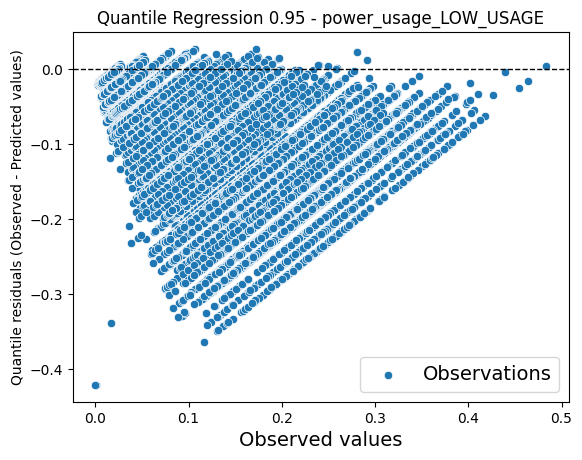

mape: 1.1136001452267406
mse: 381813679.542612
rmse: 19540.053212379233
R-squared score: -1.394844117791358
Standard deviation: 20741.313118499795
Quantile loss with library:  820.9452312287622
------------------------------
Target: medium_latency_LOW_USAGE
mape: 45.87878330985807
mse: 0.0020414005492620318
rmse: 0.04518186084328568
R-squared score: -0.5902687741984962
Standard deviation: 0.04126444226707055


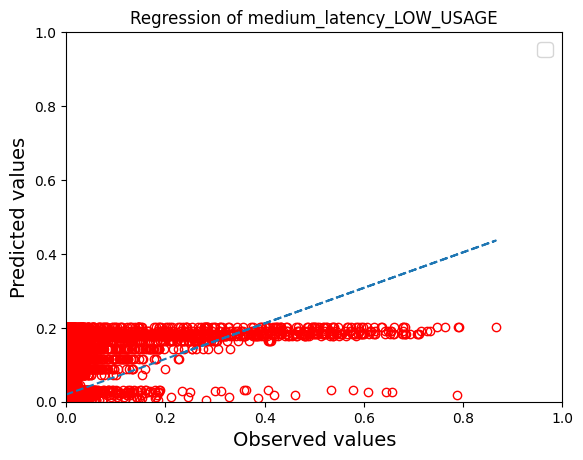

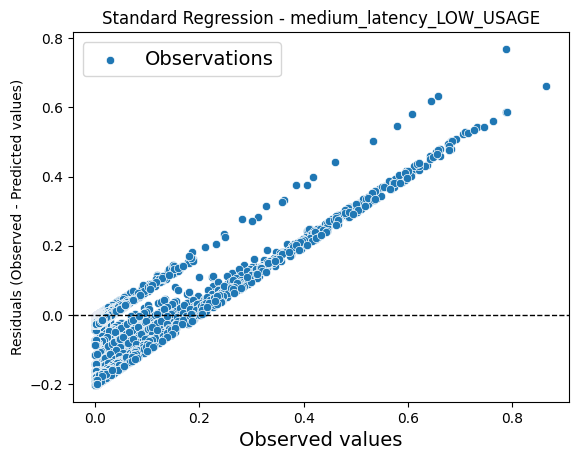

mape: 24.106410405742718
mse: 1.5912402092735562e+18
rmse: 1261443700.3979037
R-squared score: -0.5902687741984964
Standard deviation: 1152072309.0351536
------------------------------
Target: medium_latency_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 13.981197317076557 % of cases and less or equal in 86.01880268292345 % of cases.
mape: 0.5350379522007109
mse: 0.0012992784489984745
rmse: 0.03604550525375493
R-squared score: -0.012149206670029278
Standard deviation: 0.000273594953696624
Quantile loss with library:  0.0002558267633075724
Prediction for alpha 0.95 are greater than true values in 99.68893641249254 % of cases and less or equal in 0.3110635875074641 % of cases.
mape: 210.7166911092047
mse: 0.02568641000252516
rmse: 0.16026980377639813
R-squared score: -19.009936689319684
Standard deviation: 0.14325174304719016
Quantile loss with library:  0.0045687641296119335


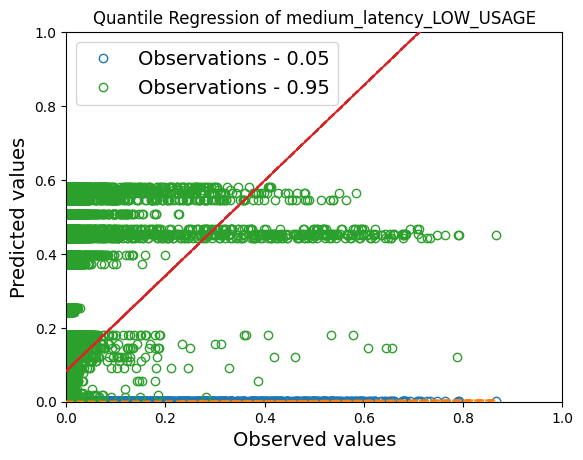

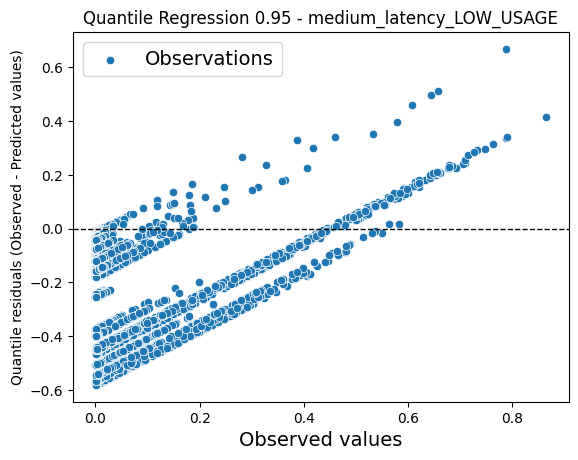

mape: 110.26270348334383
mse: 2.0022160003180274e+19
rmse: 4474612832.768917
R-squared score: -19.00993668931968
Standard deviation: 3999481328.6835003
Quantile loss with library:  127556471.16644464
------------------------------


In [242]:
pred_only_metrics, pred_only_metrics_no_scale = compute_metrics_and_plot(pred_only_predictions, y_test_dict_pred, y_scalers)

In [243]:
pred_only_metrics.to_csv("output/metrics/groups/pred_only_metrics.csv")
pred_only_metrics

mape       mse      rmse         r2  \
cpu_usage_LOW_USAGE                   2.007287  0.015437  0.124246 -10.528944   
cpu_usage_LOW_USAGE quantiles         4.982865  0.092776  0.304591 -68.287992   
medium_latency_LOW_USAGE             45.878783  0.002041  0.045182  -0.590269   
medium_latency_LOW_USAGE quantiles  210.716691  0.025686   0.16027 -19.009937   
power_usage_LOW_USAGE                 0.364824  0.001471  0.038355   0.731201   
power_usage_LOW_USAGE quantiles       1.155124  0.013107  0.114484  -1.394844   
ram_usage_LOW_USAGE                  47.800458  0.033258  0.182367  -2.648977   
ram_usage_LOW_USAGE quantiles       139.190624  0.330452  0.574849   -35.2564   

                                                     quantile_loss   std_dev  \
cpu_usage_LOW_USAGE                 Not calculated for this target  0.093052   
cpu_usage_LOW_USAGE quantiles                             0.013606  0.172059   
medium_latency_LOW_USAGE            Not calculated for this target  0.041264   
medium_latency_LOW_USAGE quantiles                        0.004569  0.143252   
power_usage_LOW_USAGE               Not calculated for this target  0.077263   
power_usage_LOW_USAGE quantiles                            0.00481  0.121522   
ram_usage_LOW_USAGE                 Not calculated for this target  0.079219   
ram_usage_LOW_USAGE quantiles                             0.027948  0.116002   

                                                                metric  
cpu_usage_LOW_USAGE                                cpu_usage_LOW_USAGE  
cpu_usage_LOW_USAGE quantiles            cpu_usage_LOW_USAGE quantiles  
medium_latency_LOW_USAGE                      medium_latency_LOW_USAGE  
medium_latency_LOW_USAGE quantiles  medium_latency_LOW_USAGE quantiles  
power_usage_LOW_USAGE                            power_usage_LOW_USAGE  
power_usage_LOW_USAGE quantiles        power_usage_LOW_USAGE quantiles  
ram_usage_LOW_USAGE                                ram_usage_LOW_USAGE  
ram_usage_LOW_USAGE quantiles            ram_usage_LOW_USAGE quantiles

In [244]:
pred_only_metrics_no_scale.to_csv("output/metrics/groups/pred_only_metrics_no_scale.csv")
pred_only_metrics_no_scale

mape                     mse  \
cpu_usage_LOW_USAGE                    1.95058              312.300136   
cpu_usage_LOW_USAGE quantiles         4.854695             1876.897795   
medium_latency_LOW_USAGE              24.10641   1591240209273556224.0   
medium_latency_LOW_USAGE quantiles  110.262703  20022160003180273664.0   
power_usage_LOW_USAGE                 0.341573         42855077.195012   
power_usage_LOW_USAGE quantiles         1.1136        381813679.542612   
ram_usage_LOW_USAGE                  16.755823      3795093923832157.0   
ram_usage_LOW_USAGE quantiles        52.258922     37708227061391264.0   

                                                 rmse         r2  \
cpu_usage_LOW_USAGE                         17.672016 -10.528944   
cpu_usage_LOW_USAGE quantiles               43.323178 -68.287992   
medium_latency_LOW_USAGE            1261443700.397904  -0.590269   
medium_latency_LOW_USAGE quantiles  4474612832.768917 -19.009937   
power_usage_LOW_USAGE                     6546.378938   0.731201   
power_usage_LOW_USAGE quantiles          19540.053212  -1.394844   
ram_usage_LOW_USAGE                     61604333.6449  -2.648977   
ram_usage_LOW_USAGE quantiles        194186062.994725   -35.2564   

                                                     quantile_loss  \
cpu_usage_LOW_USAGE                 Not calculated for this target   
cpu_usage_LOW_USAGE quantiles                              1.93526   
medium_latency_LOW_USAGE            Not calculated for this target   
medium_latency_LOW_USAGE quantiles                127556471.166445   
power_usage_LOW_USAGE               Not calculated for this target   
power_usage_LOW_USAGE quantiles                         820.945231   
ram_usage_LOW_USAGE                 Not calculated for this target   
ram_usage_LOW_USAGE quantiles                       9440989.794976   

                                              std_dev  \
cpu_usage_LOW_USAGE                         13.235113   
cpu_usage_LOW_USAGE quantiles               24.472646   
medium_latency_LOW_USAGE            1152072309.035154   
medium_latency_LOW_USAGE quantiles    3999481328.6835   
power_usage_LOW_USAGE                    13187.180913   
power_usage_LOW_USAGE quantiles          20741.313118   
ram_usage_LOW_USAGE                   26760469.716666   
ram_usage_LOW_USAGE quantiles         39185939.463322   

                                                                metric  
cpu_usage_LOW_USAGE                                cpu_usage_LOW_USAGE  
cpu_usage_LOW_USAGE quantiles            cpu_usage_LOW_USAGE quantiles  
medium_latency_LOW_USAGE                      medium_latency_LOW_USAGE  
medium_latency_LOW_USAGE quantiles  medium_latency_LOW_USAGE quantiles  
power_usage_LOW_USAGE                            power_usage_LOW_USAGE  
power_usage_LOW_USAGE quantiles        power_usage_LOW_USAGE quantiles  
ram_usage_LOW_USAGE                                ram_usage_LOW_USAGE  
ram_usage_LOW_USAGE quantiles            ram_usage_LOW_USAGE quantiles